In [34]:
import os
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import random
import glob
import numpy as np
import cv2
from sklearn.utils import shuffle

## Function of loading dataset

In [35]:
def load_train(train_path, image_size, classes):
    images = []
    labels = []
    ids = []
    cls = []

    print('Reading training images')
    for fld in classes:   # assuming data directory has a separate folder for each class, and that each folder is named after the class
        index = classes.index(fld)
        print('Loading {} files (Index: {})'.format(fld, index))
        path = os.path.join(train_path, fld, '*g')
        files = glob.glob(path)
        for fl in files:
            image = cv2.imread(fl)
            image = cv2.resize(image, (image_size, image_size), interpolation = cv2.INTER_LINEAR)
            images.append(image)
            label = np.zeros(len(classes))
            label[index] = 1.0
            labels.append(label)
            flbase = os.path.basename(fl)
            ids.append(flbase)
            cls.append(fld)
    images = np.array(images)
    labels = np.array(labels)
    ids = np.array(ids)
    cls = np.array(cls)

    return images, labels, ids, cls


def load_test(test_path, image_size):
    path = os.path.join(test_path, '*g')
    files = sorted(glob.glob(path))

    X_test = []
    X_test_id = []
    print("Reading test images")
    for fl in files:
        flbase = os.path.basename(fl)
        img = cv2.imread(fl)
        img = cv2.resize(img, (image_size, image_size), interpolation = cv2.INTER_LINEAR)
        X_test.append(img)
        X_test_id.append(flbase)

### because we're not creating a DataSet object for the test images, normalization happens here
    X_test = np.array(X_test, dtype=np.uint8)
    X_test = X_test.astype('float32')
    X_test = X_test / 255

    return X_test, X_test_id



class DataSet(object):

    def __init__(self, images, labels, ids, cls):
        """Construct a DataSet. one_hot arg is used only if fake_data is true."""

        self._num_examples = images.shape[0]


        # Convert shape from [num examples, rows, columns, depth]
        # to [num examples, rows*columns] (assuming depth == 1)
        # Convert from [0, 255] -> [0.0, 1.0].

        images = images.astype(np.float32)
        images = np.multiply(images, 1.0 / 255.0)

        self._images = images
        self._labels = labels
        self._ids = ids
        self._cls = cls
        self._epochs_completed = 0
        self._index_in_epoch = 0

    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._labels

    @property
    def ids(self):
        return self._ids

    @property
    def cls(self):
        return self._cls

    @property
    def num_examples(self):
        return self._num_examples

    @property
    def epochs_completed(self):
        return self._epochs_completed

    def next_batch(self, batch_size):
        """Return the next `batch_size` examples from this data set."""
        start = self._index_in_epoch
        self._index_in_epoch += batch_size

        if self._index_in_epoch > self._num_examples:
            # Finished epoch
            self._epochs_completed += 1

            # # Shuffle the data (maybe)
            # perm = np.arange(self._num_examples)
            # np.random.shuffle(perm)
            # self._images = self._images[perm]
            # self._labels = self._labels[perm]
            # Start next epoch

            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch

        return self._images[start:end], self._labels[start:end], self._ids[start:end], self._cls[start:end]


def read_train_sets(train_path, image_size, classes, validation_size=0):
    class DataSets(object):
        pass
    data_sets = DataSets()

    images, labels, ids, cls = load_train(train_path, image_size, classes)
    images, labels, ids, cls = shuffle(images, labels, ids, cls)  # shuffle the data

    if isinstance(validation_size, float):
        validation_size = int(validation_size * images.shape[0])

        validation_images = images[:validation_size]
        validation_labels = labels[:validation_size]
        validation_ids = ids[:validation_size]
        validation_cls = cls[:validation_size]

        train_images = images[validation_size:]
        train_labels = labels[validation_size:]
        train_ids = ids[validation_size:]
        train_cls = cls[validation_size:]

        data_sets.train = DataSet(train_images, train_labels, train_ids, train_cls)
        data_sets.valid = DataSet(validation_images, validation_labels, validation_ids, validation_cls)

    return data_sets


def read_test_set(test_path, image_size):
    images, ids  = load_test(test_path, image_size)
    return images, ids

## Configuration and Hyperparameters

In [36]:
# Convolutional Layer 1.
filter_size1 = 5 
num_filters1 = 64

# Convolutional Layer 2.
filter_size2 = 3
num_filters2 = 64

# # Convolutional Layer 3.
# filter_size3 = 5
# num_filters3 = 128

# Fully-connected layer 1.
fc1_size = 128             # Number of neurons in fully-connected layer.

# Fully-connected layer 2.
fc2_size = 128             # Number of neurons in fully-connected layer.

# Number of color channels for the images: 1 channel for gray-scale.
num_channels = 3

# image dimensions (only squares for now)
img_size = 64

# Size of image when flattened to a single dimension
img_size_flat = img_size * img_size * num_channels

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

#class info
classes = ['1beixie','2bohen','3buluti',
           '4cahen','5changzhuangzhezhou','6duanceng',
          '7yanmai','11jiehe','8nilie','9shixiangchang','10xuanwuyanzhu','12pianmayan']
#classes = ['Abyssinian','Bengal','Birman',
#          'Bombay','British_shorthair','Maine_Coon','Persian','Ragdoll','Siamese','Sphynx']

# classes = ['Sphynx','Siamese',
#            'Persian','Maine_Coon','British_shorthair']

num_classes = len(classes)

# batch size
batch_size = 32

# validation split
validation_size = .1

# how long to wait after validation loss stops improving before terminating training
early_stopping = None  # use None if you don't want to implement early stoping

train_path = 'dataset'
# test_path = 'test'
checkpoint_dir = "ckpoint"

In [37]:
# load training dataset
data = read_train_sets(train_path, img_size, classes, validation_size=validation_size)
# test_images, test_ids = read_test_set(test_path, img_size)

Reading training images
Loading 1beixie files (Index: 0)
Loading 2bohen files (Index: 1)
Loading 3buluti files (Index: 2)
Loading 4cahen files (Index: 3)
Loading 5changzhuangzhezhou files (Index: 4)
Loading 6duanceng files (Index: 5)
Loading 7yanmai files (Index: 6)
Loading 11jiehe files (Index: 7)
Loading 8nilie files (Index: 8)
Loading 9shixiangchang files (Index: 9)
Loading 10xuanwuyanzhu files (Index: 10)
Loading 12pianmayan files (Index: 11)


In [38]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
# print("- Test-set:\t\t{}".format(len(test_images)))
print("- Validation:\t{}".format(len(data.valid.labels)))
# print(images)

Size of:
- Training-set:		5573
- Validation:	619


### Helper-function for plotting images

In [39]:

def plot_images(images, cls_true, cls_pred=None):
    
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))
        
        
    images, cls_true  = zip(*[(images[i], cls_true[i]) for i in random_indices])
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_size, img_size, num_channels))

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

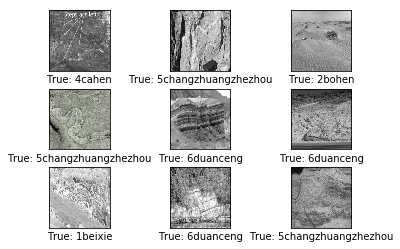

In [40]:
# Get some random images and their labels from the train set.

images, cls_true  = data.train.images, data.train.cls

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## TensorFlow Graph

### Helper-functions for creating new variables

In [41]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))


### Convolutional Layer

In [42]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

###  Flattening a layer

In [43]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

### Fully-Connected Layer

In [44]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

### Placeholder variables

In [45]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

### Convolutional Layer 1

In [46]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)
layer_conv1

<tf.Tensor 'Relu_3:0' shape=(?, 32, 32, 64) dtype=float32>

### Convolutional Layers 2 and 3

In [47]:
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)
    
# layer_conv3, weights_conv3 = \
#     new_conv_layer(input=layer_conv2,
#                    num_input_channels=num_filters2,
#                    filter_size=filter_size3,
#                    num_filters=num_filters3,
#                    use_pooling=True)
# print(layer_conv3, layer_conv2)

### Flatten Layer

In [48]:
# layer_flat, num_features = flatten_layer(layer_conv3)
# print(layer_flat, num_features)

layer_flat, num_features = flatten_layer(layer_conv2)
print(layer_flat, num_features)

(<tf.Tensor 'Reshape_3:0' shape=(?, 16384) dtype=float32>, 16384)


### Fully-Connected Layer 1

In [49]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc1_size,
                         use_relu=True)
layer_fc1

<tf.Tensor 'Relu_5:0' shape=(?, 128) dtype=float32>

### Fully-Connected Layer 2

In [50]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc1_size,
                         num_outputs=num_classes,
                         use_relu=False)
layer_fc2

<tf.Tensor 'add_7:0' shape=(?, 12) dtype=float32>

### Predicted Class

In [51]:
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, dimension=1)


### Cost-function to be optimized

In [52]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

### Performance Measures

In [53]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow Run

In [54]:
session = tf.Session()
session.run(tf.global_variables_initializer())

train_batch_size = batch_size

In [26]:
# def print_progress(epoch, feed_dict_train, feed_dict_validate, val_loss):
#     # Calculate the accuracy on the training-set.
#     acc = session.run(accuracy, feed_dict=feed_dict_train)
#     val_acc = session.run(accuracy, feed_dict=feed_dict_validate)
#     msg = "Epoch {0} --- Training Accuracy: {1:>6.1%}, Validation Accuracy: {2:>6.1%}, Validation Loss: {3:.3f}"
#     print(msg.format(epoch + 1, acc, val_acc, val_loss))

In [55]:
def print_progress(epoch, feed_dict_train, feed_dict_validate, val_loss):
    # Calculate the accuracy on the training-set.
    acc = session.run(accuracy, feed_dict=feed_dict_train)
    val_acc = session.run(accuracy, feed_dict=feed_dict_validate)
    msg = "Iteration {0} --- Training Accuracy: {1:>6.1%}, Validation Accuracy: {2:>6.1%}, Validation Loss: {3:.3f}"
    print(msg.format(epoch + 1, acc, val_acc, val_loss))

In [56]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    best_val_loss = float("inf")
    patience = 0

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch, _, cls_batch = data.train.next_batch(train_batch_size)
        x_valid_batch, y_valid_batch, _, valid_cls_batch = data.valid.next_batch(train_batch_size)

        # Convert shape from [num examples, rows, columns, depth]
        # to [num examples, flattened image shape]

        x_batch = x_batch.reshape(train_batch_size, img_size_flat)
        x_valid_batch = x_valid_batch.reshape(train_batch_size, img_size_flat)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}
        
        feed_dict_validate = {x: x_valid_batch,
                              y_true: y_valid_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)
        

        # Print status at end of each epoch (defined as full pass through training dataset).
        
        #if i % int(data.train.num_examples/batch_size) == 0: 
            #val_loss = session.run(cost, feed_dict=feed_dict_validate)
            #epoch = int(i / int(data.train.num_examples/batch_size))
            
            
        
        val_loss = session.run(cost, feed_dict=feed_dict_validate)
        epoch = int(i)
            
        print_progress(epoch, feed_dict_train, feed_dict_validate, val_loss)
            
  #          if early_stopping:    
  #              if val_loss < best_val_loss:
  #                  best_val_loss = val_loss
  #                  patience = 0
   #             else:
   #                 patience += 1
#
   #             if patience == early_stopping:
   #                 break

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time elapsed: " + str(timedelta(seconds=int(round(time_dif)))))

In [57]:
optimize(num_iterations=20000)

Epoch 2 --- Training Accuracy:  21.9%, Validation Accuracy:  15.6%, Validation Loss: 2.438
Epoch 3 --- Training Accuracy:  15.6%, Validation Accuracy:  31.2%, Validation Loss: 2.208
Epoch 4 --- Training Accuracy:  28.1%, Validation Accuracy:  18.8%, Validation Loss: 2.230
Epoch 5 --- Training Accuracy:  12.5%, Validation Accuracy:   6.2%, Validation Loss: 2.336
Epoch 6 --- Training Accuracy:   6.2%, Validation Accuracy:   9.4%, Validation Loss: 2.279
Epoch 7 --- Training Accuracy:  21.9%, Validation Accuracy:  21.9%, Validation Loss: 2.121
Epoch 8 --- Training Accuracy:  18.8%, Validation Accuracy:  31.2%, Validation Loss: 2.049
Epoch 9 --- Training Accuracy:  28.1%, Validation Accuracy:  25.0%, Validation Loss: 2.064
Epoch 10 --- Training Accuracy:   9.4%, Validation Accuracy:   9.4%, Validation Loss: 2.222
Epoch 11 --- Training Accuracy:   3.1%, Validation Accuracy:  25.0%, Validation Loss: 2.018
Epoch 12 --- Training Accuracy:  28.1%, Validation Accuracy:   9.4%, Validation Loss: 2.

Epoch 92 --- Training Accuracy:  18.8%, Validation Accuracy:  12.5%, Validation Loss: 1.979
Epoch 93 --- Training Accuracy:  21.9%, Validation Accuracy:  15.6%, Validation Loss: 2.039
Epoch 94 --- Training Accuracy:  12.5%, Validation Accuracy:   9.4%, Validation Loss: 2.035
Epoch 95 --- Training Accuracy:  18.8%, Validation Accuracy:  21.9%, Validation Loss: 1.947
Epoch 96 --- Training Accuracy:   9.4%, Validation Accuracy:  15.6%, Validation Loss: 2.120
Epoch 97 --- Training Accuracy:  12.5%, Validation Accuracy:  28.1%, Validation Loss: 1.895
Epoch 98 --- Training Accuracy:  37.5%, Validation Accuracy:  18.8%, Validation Loss: 1.943
Epoch 99 --- Training Accuracy:   6.2%, Validation Accuracy:  12.5%, Validation Loss: 1.968
Epoch 100 --- Training Accuracy:  15.6%, Validation Accuracy:  21.9%, Validation Loss: 2.004
Epoch 101 --- Training Accuracy:  31.2%, Validation Accuracy:   9.4%, Validation Loss: 1.963
Epoch 102 --- Training Accuracy:  15.6%, Validation Accuracy:  18.8%, Validati

Epoch 181 --- Training Accuracy:  25.0%, Validation Accuracy:   9.4%, Validation Loss: 1.955
Epoch 182 --- Training Accuracy:  18.8%, Validation Accuracy:  25.0%, Validation Loss: 1.871
Epoch 183 --- Training Accuracy:  28.1%, Validation Accuracy:   9.4%, Validation Loss: 1.938
Epoch 184 --- Training Accuracy:   9.4%, Validation Accuracy:   9.4%, Validation Loss: 1.965
Epoch 185 --- Training Accuracy:   6.2%, Validation Accuracy:  18.8%, Validation Loss: 1.917
Epoch 186 --- Training Accuracy:  25.0%, Validation Accuracy:  18.8%, Validation Loss: 1.925
Epoch 187 --- Training Accuracy:  34.4%, Validation Accuracy:  12.5%, Validation Loss: 1.917
Epoch 188 --- Training Accuracy:  34.4%, Validation Accuracy:  15.6%, Validation Loss: 1.925
Epoch 189 --- Training Accuracy:  28.1%, Validation Accuracy:  37.5%, Validation Loss: 1.806
Epoch 190 --- Training Accuracy:  12.5%, Validation Accuracy:  25.0%, Validation Loss: 1.859
Epoch 191 --- Training Accuracy:  28.1%, Validation Accuracy:  12.5%, 

Epoch 270 --- Training Accuracy:  15.6%, Validation Accuracy:  28.1%, Validation Loss: 1.874
Epoch 271 --- Training Accuracy:  18.8%, Validation Accuracy:  15.6%, Validation Loss: 2.036
Epoch 272 --- Training Accuracy:  40.6%, Validation Accuracy:  31.2%, Validation Loss: 1.885
Epoch 273 --- Training Accuracy:   6.2%, Validation Accuracy:  34.4%, Validation Loss: 1.841
Epoch 274 --- Training Accuracy:  28.1%, Validation Accuracy:  28.1%, Validation Loss: 1.864
Epoch 275 --- Training Accuracy:  40.6%, Validation Accuracy:  25.0%, Validation Loss: 1.796
Epoch 276 --- Training Accuracy:  25.0%, Validation Accuracy:  25.0%, Validation Loss: 1.887
Epoch 277 --- Training Accuracy:  28.1%, Validation Accuracy:  37.5%, Validation Loss: 1.816
Epoch 278 --- Training Accuracy:  28.1%, Validation Accuracy:  31.2%, Validation Loss: 1.803
Epoch 279 --- Training Accuracy:  53.1%, Validation Accuracy:  25.0%, Validation Loss: 1.816
Epoch 280 --- Training Accuracy:  15.6%, Validation Accuracy:  18.8%, 

Epoch 359 --- Training Accuracy:  15.6%, Validation Accuracy:  18.8%, Validation Loss: 1.951
Epoch 360 --- Training Accuracy:  21.9%, Validation Accuracy:  37.5%, Validation Loss: 1.706
Epoch 361 --- Training Accuracy:  43.8%, Validation Accuracy:  25.0%, Validation Loss: 1.778
Epoch 362 --- Training Accuracy:  40.6%, Validation Accuracy:  25.0%, Validation Loss: 1.850
Epoch 363 --- Training Accuracy:  37.5%, Validation Accuracy:  31.2%, Validation Loss: 1.762
Epoch 364 --- Training Accuracy:  31.2%, Validation Accuracy:  56.2%, Validation Loss: 1.663
Epoch 365 --- Training Accuracy:  25.0%, Validation Accuracy:  43.8%, Validation Loss: 1.761
Epoch 366 --- Training Accuracy:  28.1%, Validation Accuracy:  40.6%, Validation Loss: 1.870
Epoch 367 --- Training Accuracy:  31.2%, Validation Accuracy:  31.2%, Validation Loss: 1.812
Epoch 368 --- Training Accuracy:  25.0%, Validation Accuracy:  34.4%, Validation Loss: 1.771
Epoch 369 --- Training Accuracy:  31.2%, Validation Accuracy:  25.0%, 

Epoch 448 --- Training Accuracy:  34.4%, Validation Accuracy:  31.2%, Validation Loss: 1.773
Epoch 449 --- Training Accuracy:  31.2%, Validation Accuracy:  31.2%, Validation Loss: 1.772
Epoch 450 --- Training Accuracy:  34.4%, Validation Accuracy:  31.2%, Validation Loss: 1.772
Epoch 451 --- Training Accuracy:  25.0%, Validation Accuracy:  28.1%, Validation Loss: 1.847
Epoch 452 --- Training Accuracy:  34.4%, Validation Accuracy:  28.1%, Validation Loss: 1.802
Epoch 453 --- Training Accuracy:  56.2%, Validation Accuracy:  34.4%, Validation Loss: 1.832
Epoch 454 --- Training Accuracy:  37.5%, Validation Accuracy:  25.0%, Validation Loss: 1.959
Epoch 455 --- Training Accuracy:  37.5%, Validation Accuracy:  28.1%, Validation Loss: 1.754
Epoch 456 --- Training Accuracy:  37.5%, Validation Accuracy:  28.1%, Validation Loss: 1.789
Epoch 457 --- Training Accuracy:  25.0%, Validation Accuracy:  31.2%, Validation Loss: 1.794
Epoch 458 --- Training Accuracy:  28.1%, Validation Accuracy:  34.4%, 

Epoch 537 --- Training Accuracy:  34.4%, Validation Accuracy:  40.6%, Validation Loss: 1.774
Epoch 538 --- Training Accuracy:  46.9%, Validation Accuracy:  40.6%, Validation Loss: 1.753
Epoch 539 --- Training Accuracy:  37.5%, Validation Accuracy:  37.5%, Validation Loss: 1.650
Epoch 540 --- Training Accuracy:  31.2%, Validation Accuracy:  25.0%, Validation Loss: 1.860
Epoch 541 --- Training Accuracy:  31.2%, Validation Accuracy:  37.5%, Validation Loss: 1.713
Epoch 542 --- Training Accuracy:  28.1%, Validation Accuracy:  40.6%, Validation Loss: 1.637
Epoch 543 --- Training Accuracy:  28.1%, Validation Accuracy:  18.8%, Validation Loss: 1.774
Epoch 544 --- Training Accuracy:  37.5%, Validation Accuracy:  37.5%, Validation Loss: 1.682
Epoch 545 --- Training Accuracy:  34.4%, Validation Accuracy:  31.2%, Validation Loss: 1.696
Epoch 546 --- Training Accuracy:  37.5%, Validation Accuracy:  31.2%, Validation Loss: 1.839
Epoch 547 --- Training Accuracy:  25.0%, Validation Accuracy:  40.6%, 

Epoch 626 --- Training Accuracy:  37.5%, Validation Accuracy:  40.6%, Validation Loss: 1.682
Epoch 627 --- Training Accuracy:  46.9%, Validation Accuracy:  37.5%, Validation Loss: 1.686
Epoch 628 --- Training Accuracy:  40.6%, Validation Accuracy:  25.0%, Validation Loss: 1.752
Epoch 629 --- Training Accuracy:  34.4%, Validation Accuracy:  40.6%, Validation Loss: 1.622
Epoch 630 --- Training Accuracy:  37.5%, Validation Accuracy:  53.1%, Validation Loss: 1.547
Epoch 631 --- Training Accuracy:  31.2%, Validation Accuracy:  34.4%, Validation Loss: 1.640
Epoch 632 --- Training Accuracy:  28.1%, Validation Accuracy:  37.5%, Validation Loss: 1.777
Epoch 633 --- Training Accuracy:  40.6%, Validation Accuracy:  34.4%, Validation Loss: 1.751
Epoch 634 --- Training Accuracy:  37.5%, Validation Accuracy:  43.8%, Validation Loss: 1.522
Epoch 635 --- Training Accuracy:  43.8%, Validation Accuracy:  25.0%, Validation Loss: 1.820
Epoch 636 --- Training Accuracy:  43.8%, Validation Accuracy:  40.6%, 

Epoch 715 --- Training Accuracy:  31.2%, Validation Accuracy:  34.4%, Validation Loss: 1.632
Epoch 716 --- Training Accuracy:  28.1%, Validation Accuracy:  34.4%, Validation Loss: 1.663
Epoch 717 --- Training Accuracy:  31.2%, Validation Accuracy:  25.0%, Validation Loss: 1.800
Epoch 718 --- Training Accuracy:  43.8%, Validation Accuracy:  37.5%, Validation Loss: 1.707
Epoch 719 --- Training Accuracy:  37.5%, Validation Accuracy:  40.6%, Validation Loss: 1.777
Epoch 720 --- Training Accuracy:  46.9%, Validation Accuracy:  21.9%, Validation Loss: 1.791
Epoch 721 --- Training Accuracy:  31.2%, Validation Accuracy:  28.1%, Validation Loss: 1.712
Epoch 722 --- Training Accuracy:  43.8%, Validation Accuracy:  34.4%, Validation Loss: 1.655
Epoch 723 --- Training Accuracy:  53.1%, Validation Accuracy:  37.5%, Validation Loss: 1.705
Epoch 724 --- Training Accuracy:  46.9%, Validation Accuracy:  31.2%, Validation Loss: 1.614
Epoch 725 --- Training Accuracy:  43.8%, Validation Accuracy:  50.0%, 

Epoch 804 --- Training Accuracy:  34.4%, Validation Accuracy:  43.8%, Validation Loss: 1.722
Epoch 805 --- Training Accuracy:  37.5%, Validation Accuracy:  46.9%, Validation Loss: 1.415
Epoch 806 --- Training Accuracy:  37.5%, Validation Accuracy:  31.2%, Validation Loss: 1.741
Epoch 807 --- Training Accuracy:  37.5%, Validation Accuracy:  43.8%, Validation Loss: 1.557
Epoch 808 --- Training Accuracy:  40.6%, Validation Accuracy:  59.4%, Validation Loss: 1.478
Epoch 809 --- Training Accuracy:  43.8%, Validation Accuracy:  31.2%, Validation Loss: 1.614
Epoch 810 --- Training Accuracy:  46.9%, Validation Accuracy:  34.4%, Validation Loss: 1.569
Epoch 811 --- Training Accuracy:  40.6%, Validation Accuracy:  28.1%, Validation Loss: 1.573
Epoch 812 --- Training Accuracy:  28.1%, Validation Accuracy:  28.1%, Validation Loss: 1.785
Epoch 813 --- Training Accuracy:  53.1%, Validation Accuracy:  37.5%, Validation Loss: 1.634
Epoch 814 --- Training Accuracy:  46.9%, Validation Accuracy:  28.1%, 

Epoch 893 --- Training Accuracy:  40.6%, Validation Accuracy:  34.4%, Validation Loss: 1.569
Epoch 894 --- Training Accuracy:  50.0%, Validation Accuracy:  37.5%, Validation Loss: 1.618
Epoch 895 --- Training Accuracy:  37.5%, Validation Accuracy:  43.8%, Validation Loss: 1.537
Epoch 896 --- Training Accuracy:  43.8%, Validation Accuracy:  46.9%, Validation Loss: 1.501
Epoch 897 --- Training Accuracy:  53.1%, Validation Accuracy:  46.9%, Validation Loss: 1.555
Epoch 898 --- Training Accuracy:  46.9%, Validation Accuracy:  59.4%, Validation Loss: 1.523
Epoch 899 --- Training Accuracy:  40.6%, Validation Accuracy:  40.6%, Validation Loss: 1.689
Epoch 900 --- Training Accuracy:  43.8%, Validation Accuracy:  50.0%, Validation Loss: 1.462
Epoch 901 --- Training Accuracy:  50.0%, Validation Accuracy:  40.6%, Validation Loss: 1.627
Epoch 902 --- Training Accuracy:  53.1%, Validation Accuracy:  43.8%, Validation Loss: 1.521
Epoch 903 --- Training Accuracy:  56.2%, Validation Accuracy:  50.0%, 

Epoch 982 --- Training Accuracy:  40.6%, Validation Accuracy:  34.4%, Validation Loss: 1.529
Epoch 983 --- Training Accuracy:  43.8%, Validation Accuracy:  25.0%, Validation Loss: 1.764
Epoch 984 --- Training Accuracy:  56.2%, Validation Accuracy:  40.6%, Validation Loss: 1.571
Epoch 985 --- Training Accuracy:  53.1%, Validation Accuracy:  31.2%, Validation Loss: 1.634
Epoch 986 --- Training Accuracy:  46.9%, Validation Accuracy:  37.5%, Validation Loss: 1.666
Epoch 987 --- Training Accuracy:  46.9%, Validation Accuracy:  37.5%, Validation Loss: 1.578
Epoch 988 --- Training Accuracy:  43.8%, Validation Accuracy:  43.8%, Validation Loss: 1.516
Epoch 989 --- Training Accuracy:  40.6%, Validation Accuracy:  40.6%, Validation Loss: 1.573
Epoch 990 --- Training Accuracy:  40.6%, Validation Accuracy:  59.4%, Validation Loss: 1.472
Epoch 991 --- Training Accuracy:  46.9%, Validation Accuracy:  56.2%, Validation Loss: 1.426
Epoch 992 --- Training Accuracy:  43.8%, Validation Accuracy:  43.8%, 

Epoch 1070 --- Training Accuracy:  56.2%, Validation Accuracy:  46.9%, Validation Loss: 1.627
Epoch 1071 --- Training Accuracy:  56.2%, Validation Accuracy:  56.2%, Validation Loss: 1.424
Epoch 1072 --- Training Accuracy:  46.9%, Validation Accuracy:  40.6%, Validation Loss: 1.632
Epoch 1073 --- Training Accuracy:  37.5%, Validation Accuracy:  40.6%, Validation Loss: 1.473
Epoch 1074 --- Training Accuracy:  53.1%, Validation Accuracy:  56.2%, Validation Loss: 1.394
Epoch 1075 --- Training Accuracy:  53.1%, Validation Accuracy:  40.6%, Validation Loss: 1.510
Epoch 1076 --- Training Accuracy:  56.2%, Validation Accuracy:  43.8%, Validation Loss: 1.500
Epoch 1077 --- Training Accuracy:  62.5%, Validation Accuracy:  34.4%, Validation Loss: 1.615
Epoch 1078 --- Training Accuracy:  25.0%, Validation Accuracy:  40.6%, Validation Loss: 1.653
Epoch 1079 --- Training Accuracy:  43.8%, Validation Accuracy:  50.0%, Validation Loss: 1.527
Epoch 1080 --- Training Accuracy:  71.9%, Validation Accurac

Epoch 1158 --- Training Accuracy:  56.2%, Validation Accuracy:  37.5%, Validation Loss: 1.539
Epoch 1159 --- Training Accuracy:  56.2%, Validation Accuracy:  46.9%, Validation Loss: 1.456
Epoch 1160 --- Training Accuracy:  56.2%, Validation Accuracy:  46.9%, Validation Loss: 1.483
Epoch 1161 --- Training Accuracy:  46.9%, Validation Accuracy:  53.1%, Validation Loss: 1.389
Epoch 1162 --- Training Accuracy:  46.9%, Validation Accuracy:  59.4%, Validation Loss: 1.349
Epoch 1163 --- Training Accuracy:  40.6%, Validation Accuracy:  56.2%, Validation Loss: 1.380
Epoch 1164 --- Training Accuracy:  43.8%, Validation Accuracy:  53.1%, Validation Loss: 1.426
Epoch 1165 --- Training Accuracy:  56.2%, Validation Accuracy:  46.9%, Validation Loss: 1.574
Epoch 1166 --- Training Accuracy:  53.1%, Validation Accuracy:  56.2%, Validation Loss: 1.367
Epoch 1167 --- Training Accuracy:  50.0%, Validation Accuracy:  46.9%, Validation Loss: 1.526
Epoch 1168 --- Training Accuracy:  43.8%, Validation Accurac

Epoch 1246 --- Training Accuracy:  53.1%, Validation Accuracy:  37.5%, Validation Loss: 1.387
Epoch 1247 --- Training Accuracy:  50.0%, Validation Accuracy:  50.0%, Validation Loss: 1.383
Epoch 1248 --- Training Accuracy:  56.2%, Validation Accuracy:  31.2%, Validation Loss: 1.500
Epoch 1249 --- Training Accuracy:  50.0%, Validation Accuracy:  37.5%, Validation Loss: 1.631
Epoch 1250 --- Training Accuracy:  59.4%, Validation Accuracy:  50.0%, Validation Loss: 1.474
Epoch 1251 --- Training Accuracy:  65.6%, Validation Accuracy:  31.2%, Validation Loss: 1.592
Epoch 1252 --- Training Accuracy:  37.5%, Validation Accuracy:  28.1%, Validation Loss: 1.648
Epoch 1253 --- Training Accuracy:  50.0%, Validation Accuracy:  46.9%, Validation Loss: 1.502
Epoch 1254 --- Training Accuracy:  71.9%, Validation Accuracy:  46.9%, Validation Loss: 1.389
Epoch 1255 --- Training Accuracy:  46.9%, Validation Accuracy:  43.8%, Validation Loss: 1.451
Epoch 1256 --- Training Accuracy:  68.8%, Validation Accurac

Epoch 1334 --- Training Accuracy:  65.6%, Validation Accuracy:  62.5%, Validation Loss: 1.274
Epoch 1335 --- Training Accuracy:  50.0%, Validation Accuracy:  62.5%, Validation Loss: 1.366
Epoch 1336 --- Training Accuracy:  53.1%, Validation Accuracy:  50.0%, Validation Loss: 1.442
Epoch 1337 --- Training Accuracy:  40.6%, Validation Accuracy:  65.6%, Validation Loss: 1.212
Epoch 1338 --- Training Accuracy:  46.9%, Validation Accuracy:  46.9%, Validation Loss: 1.445
Epoch 1339 --- Training Accuracy:  56.2%, Validation Accuracy:  46.9%, Validation Loss: 1.345
Epoch 1340 --- Training Accuracy:  56.2%, Validation Accuracy:  59.4%, Validation Loss: 1.292
Epoch 1341 --- Training Accuracy:  46.9%, Validation Accuracy:  37.5%, Validation Loss: 1.402
Epoch 1342 --- Training Accuracy:  46.9%, Validation Accuracy:  50.0%, Validation Loss: 1.374
Epoch 1343 --- Training Accuracy:  53.1%, Validation Accuracy:  46.9%, Validation Loss: 1.455
Epoch 1344 --- Training Accuracy:  46.9%, Validation Accurac

Epoch 1422 --- Training Accuracy:  62.5%, Validation Accuracy:  37.5%, Validation Loss: 1.450
Epoch 1423 --- Training Accuracy:  50.0%, Validation Accuracy:  37.5%, Validation Loss: 1.559
Epoch 1424 --- Training Accuracy:  65.6%, Validation Accuracy:  46.9%, Validation Loss: 1.427
Epoch 1425 --- Training Accuracy:  65.6%, Validation Accuracy:  50.0%, Validation Loss: 1.361
Epoch 1426 --- Training Accuracy:  37.5%, Validation Accuracy:  50.0%, Validation Loss: 1.391
Epoch 1427 --- Training Accuracy:  56.2%, Validation Accuracy:  56.2%, Validation Loss: 1.246
Epoch 1428 --- Training Accuracy:  78.1%, Validation Accuracy:  62.5%, Validation Loss: 1.271
Epoch 1429 --- Training Accuracy:  65.6%, Validation Accuracy:  53.1%, Validation Loss: 1.273
Epoch 1430 --- Training Accuracy:  68.8%, Validation Accuracy:  53.1%, Validation Loss: 1.274
Epoch 1431 --- Training Accuracy:  53.1%, Validation Accuracy:  43.8%, Validation Loss: 1.532
Epoch 1432 --- Training Accuracy:  46.9%, Validation Accurac

Epoch 1510 --- Training Accuracy:  59.4%, Validation Accuracy:  59.4%, Validation Loss: 1.315
Epoch 1511 --- Training Accuracy:  40.6%, Validation Accuracy:  62.5%, Validation Loss: 1.193
Epoch 1512 --- Training Accuracy:  50.0%, Validation Accuracy:  43.8%, Validation Loss: 1.285
Epoch 1513 --- Training Accuracy:  65.6%, Validation Accuracy:  53.1%, Validation Loss: 1.286
Epoch 1514 --- Training Accuracy:  59.4%, Validation Accuracy:  50.0%, Validation Loss: 1.399
Epoch 1515 --- Training Accuracy:  46.9%, Validation Accuracy:  31.2%, Validation Loss: 1.658
Epoch 1516 --- Training Accuracy:  53.1%, Validation Accuracy:  56.2%, Validation Loss: 1.390
Epoch 1517 --- Training Accuracy:  65.6%, Validation Accuracy:  37.5%, Validation Loss: 1.418
Epoch 1518 --- Training Accuracy:  46.9%, Validation Accuracy:  37.5%, Validation Loss: 1.555
Epoch 1519 --- Training Accuracy:  65.6%, Validation Accuracy:  50.0%, Validation Loss: 1.383
Epoch 1520 --- Training Accuracy:  65.6%, Validation Accurac

Epoch 1598 --- Training Accuracy:  62.5%, Validation Accuracy:  62.5%, Validation Loss: 1.136
Epoch 1599 --- Training Accuracy:  75.0%, Validation Accuracy:  62.5%, Validation Loss: 1.178
Epoch 1600 --- Training Accuracy:  37.5%, Validation Accuracy:  56.2%, Validation Loss: 1.173
Epoch 1601 --- Training Accuracy:  65.6%, Validation Accuracy:  53.1%, Validation Loss: 1.200
Epoch 1602 --- Training Accuracy:  81.2%, Validation Accuracy:  50.0%, Validation Loss: 1.420
Epoch 1603 --- Training Accuracy:  68.8%, Validation Accuracy:  75.0%, Validation Loss: 1.076
Epoch 1604 --- Training Accuracy:  68.8%, Validation Accuracy:  53.1%, Validation Loss: 1.334
Epoch 1605 --- Training Accuracy:  56.2%, Validation Accuracy:  46.9%, Validation Loss: 1.334
Epoch 1606 --- Training Accuracy:  56.2%, Validation Accuracy:  53.1%, Validation Loss: 1.249
Epoch 1607 --- Training Accuracy:  50.0%, Validation Accuracy:  50.0%, Validation Loss: 1.126
Epoch 1608 --- Training Accuracy:  50.0%, Validation Accurac

Epoch 1686 --- Training Accuracy:  50.0%, Validation Accuracy:  40.6%, Validation Loss: 1.563
Epoch 1687 --- Training Accuracy:  65.6%, Validation Accuracy:  59.4%, Validation Loss: 1.287
Epoch 1688 --- Training Accuracy:  65.6%, Validation Accuracy:  46.9%, Validation Loss: 1.326
Epoch 1689 --- Training Accuracy:  53.1%, Validation Accuracy:  40.6%, Validation Loss: 1.479
Epoch 1690 --- Training Accuracy:  62.5%, Validation Accuracy:  56.2%, Validation Loss: 1.289
Epoch 1691 --- Training Accuracy:  71.9%, Validation Accuracy:  46.9%, Validation Loss: 1.268
Epoch 1692 --- Training Accuracy:  56.2%, Validation Accuracy:  56.2%, Validation Loss: 1.255
Epoch 1693 --- Training Accuracy:  65.6%, Validation Accuracy:  68.8%, Validation Loss: 1.082
Epoch 1694 --- Training Accuracy:  68.8%, Validation Accuracy:  65.6%, Validation Loss: 1.110
Epoch 1695 --- Training Accuracy:  56.2%, Validation Accuracy:  59.4%, Validation Loss: 1.109
Epoch 1696 --- Training Accuracy:  78.1%, Validation Accurac

Epoch 1774 --- Training Accuracy:  46.9%, Validation Accuracy:  78.1%, Validation Loss: 0.966
Epoch 1775 --- Training Accuracy:  65.6%, Validation Accuracy:  56.2%, Validation Loss: 1.169
Epoch 1776 --- Training Accuracy:  84.4%, Validation Accuracy:  65.6%, Validation Loss: 1.167
Epoch 1777 --- Training Accuracy:  65.6%, Validation Accuracy:  68.8%, Validation Loss: 1.152
Epoch 1778 --- Training Accuracy:  75.0%, Validation Accuracy:  59.4%, Validation Loss: 1.037
Epoch 1779 --- Training Accuracy:  62.5%, Validation Accuracy:  65.6%, Validation Loss: 1.162
Epoch 1780 --- Training Accuracy:  65.6%, Validation Accuracy:  62.5%, Validation Loss: 1.207
Epoch 1781 --- Training Accuracy:  59.4%, Validation Accuracy:  37.5%, Validation Loss: 1.612
Epoch 1782 --- Training Accuracy:  53.1%, Validation Accuracy:  62.5%, Validation Loss: 1.247
Epoch 1783 --- Training Accuracy:  68.8%, Validation Accuracy:  53.1%, Validation Loss: 1.259
Epoch 1784 --- Training Accuracy:  75.0%, Validation Accurac

Epoch 1862 --- Training Accuracy:  68.8%, Validation Accuracy:  53.1%, Validation Loss: 1.222
Epoch 1863 --- Training Accuracy:  53.1%, Validation Accuracy:  53.1%, Validation Loss: 1.202
Epoch 1864 --- Training Accuracy:  68.8%, Validation Accuracy:  65.6%, Validation Loss: 1.044
Epoch 1865 --- Training Accuracy:  71.9%, Validation Accuracy:  68.8%, Validation Loss: 1.039
Epoch 1866 --- Training Accuracy:  59.4%, Validation Accuracy:  53.1%, Validation Loss: 1.074
Epoch 1867 --- Training Accuracy:  68.8%, Validation Accuracy:  65.6%, Validation Loss: 1.096
Epoch 1868 --- Training Accuracy:  68.8%, Validation Accuracy:  53.1%, Validation Loss: 1.288
Epoch 1869 --- Training Accuracy:  56.2%, Validation Accuracy:  75.0%, Validation Loss: 0.964
Epoch 1870 --- Training Accuracy:  78.1%, Validation Accuracy:  56.2%, Validation Loss: 1.217
Epoch 1871 --- Training Accuracy:  59.4%, Validation Accuracy:  59.4%, Validation Loss: 1.204
Epoch 1872 --- Training Accuracy:  56.2%, Validation Accurac

Epoch 1950 --- Training Accuracy:  84.4%, Validation Accuracy:  68.8%, Validation Loss: 1.027
Epoch 1951 --- Training Accuracy:  71.9%, Validation Accuracy:  68.8%, Validation Loss: 1.153
Epoch 1952 --- Training Accuracy:  71.9%, Validation Accuracy:  37.5%, Validation Loss: 1.559
Epoch 1953 --- Training Accuracy:  65.6%, Validation Accuracy:  68.8%, Validation Loss: 1.180
Epoch 1954 --- Training Accuracy:  65.6%, Validation Accuracy:  59.4%, Validation Loss: 1.165
Epoch 1955 --- Training Accuracy:  71.9%, Validation Accuracy:  56.2%, Validation Loss: 1.226
Epoch 1956 --- Training Accuracy:  56.2%, Validation Accuracy:  62.5%, Validation Loss: 1.223
Epoch 1957 --- Training Accuracy:  78.1%, Validation Accuracy:  50.0%, Validation Loss: 1.199
Epoch 1958 --- Training Accuracy:  78.1%, Validation Accuracy:  62.5%, Validation Loss: 1.144
Epoch 1959 --- Training Accuracy:  75.0%, Validation Accuracy:  62.5%, Validation Loss: 0.987
Epoch 1960 --- Training Accuracy:  81.2%, Validation Accurac

Epoch 2038 --- Training Accuracy:  78.1%, Validation Accuracy:  65.6%, Validation Loss: 0.982
Epoch 2039 --- Training Accuracy:  68.8%, Validation Accuracy:  53.1%, Validation Loss: 1.279
Epoch 2040 --- Training Accuracy:  65.6%, Validation Accuracy:  71.9%, Validation Loss: 0.878
Epoch 2041 --- Training Accuracy:  71.9%, Validation Accuracy:  62.5%, Validation Loss: 1.118
Epoch 2042 --- Training Accuracy:  68.8%, Validation Accuracy:  56.2%, Validation Loss: 1.091
Epoch 2043 --- Training Accuracy:  62.5%, Validation Accuracy:  71.9%, Validation Loss: 1.048
Epoch 2044 --- Training Accuracy:  78.1%, Validation Accuracy:  65.6%, Validation Loss: 0.901
Epoch 2045 --- Training Accuracy:  62.5%, Validation Accuracy:  68.8%, Validation Loss: 0.926
Epoch 2046 --- Training Accuracy:  59.4%, Validation Accuracy:  68.8%, Validation Loss: 1.094
Epoch 2047 --- Training Accuracy:  78.1%, Validation Accuracy:  46.9%, Validation Loss: 1.470
Epoch 2048 --- Training Accuracy:  68.8%, Validation Accurac

Epoch 2126 --- Training Accuracy:  78.1%, Validation Accuracy:  56.2%, Validation Loss: 1.190
Epoch 2127 --- Training Accuracy:  65.6%, Validation Accuracy:  65.6%, Validation Loss: 1.130
Epoch 2128 --- Training Accuracy:  65.6%, Validation Accuracy:  65.6%, Validation Loss: 1.139
Epoch 2129 --- Training Accuracy:  71.9%, Validation Accuracy:  53.1%, Validation Loss: 1.073
Epoch 2130 --- Training Accuracy:  68.8%, Validation Accuracy:  68.8%, Validation Loss: 0.864
Epoch 2131 --- Training Accuracy:  87.5%, Validation Accuracy:  65.6%, Validation Loss: 0.963
Epoch 2132 --- Training Accuracy:  78.1%, Validation Accuracy:  62.5%, Validation Loss: 0.947
Epoch 2133 --- Training Accuracy:  81.2%, Validation Accuracy:  65.6%, Validation Loss: 1.142
Epoch 2134 --- Training Accuracy:  87.5%, Validation Accuracy:  53.1%, Validation Loss: 1.322
Epoch 2135 --- Training Accuracy:  75.0%, Validation Accuracy:  75.0%, Validation Loss: 0.844
Epoch 2136 --- Training Accuracy:  78.1%, Validation Accurac

Epoch 2214 --- Training Accuracy:  65.6%, Validation Accuracy:  68.8%, Validation Loss: 1.042
Epoch 2215 --- Training Accuracy:  71.9%, Validation Accuracy:  65.6%, Validation Loss: 0.818
Epoch 2216 --- Training Accuracy:  75.0%, Validation Accuracy:  75.0%, Validation Loss: 0.852
Epoch 2217 --- Training Accuracy:  65.6%, Validation Accuracy:  68.8%, Validation Loss: 1.016
Epoch 2218 --- Training Accuracy:  81.2%, Validation Accuracy:  50.0%, Validation Loss: 1.410
Epoch 2219 --- Training Accuracy:  65.6%, Validation Accuracy:  75.0%, Validation Loss: 1.051
Epoch 2220 --- Training Accuracy:  62.5%, Validation Accuracy:  65.6%, Validation Loss: 0.999
Epoch 2221 --- Training Accuracy:  78.1%, Validation Accuracy:  56.2%, Validation Loss: 1.170
Epoch 2222 --- Training Accuracy:  75.0%, Validation Accuracy:  71.9%, Validation Loss: 1.082
Epoch 2223 --- Training Accuracy:  78.1%, Validation Accuracy:  62.5%, Validation Loss: 1.046
Epoch 2224 --- Training Accuracy:  87.5%, Validation Accurac

Epoch 2302 --- Training Accuracy:  68.8%, Validation Accuracy:  65.6%, Validation Loss: 0.977
Epoch 2303 --- Training Accuracy:  78.1%, Validation Accuracy:  62.5%, Validation Loss: 0.910
Epoch 2304 --- Training Accuracy:  71.9%, Validation Accuracy:  71.9%, Validation Loss: 1.056
Epoch 2305 --- Training Accuracy:  87.5%, Validation Accuracy:  56.2%, Validation Loss: 1.132
Epoch 2306 --- Training Accuracy:  78.1%, Validation Accuracy:  75.0%, Validation Loss: 0.887
Epoch 2307 --- Training Accuracy:  87.5%, Validation Accuracy:  53.1%, Validation Loss: 1.264
Epoch 2308 --- Training Accuracy:  87.5%, Validation Accuracy:  53.1%, Validation Loss: 1.064
Epoch 2309 --- Training Accuracy:  75.0%, Validation Accuracy:  65.6%, Validation Loss: 1.065
Epoch 2310 --- Training Accuracy:  81.2%, Validation Accuracy:  68.8%, Validation Loss: 0.798
Epoch 2311 --- Training Accuracy:  65.6%, Validation Accuracy:  71.9%, Validation Loss: 0.846
Epoch 2312 --- Training Accuracy:  75.0%, Validation Accurac

Epoch 2390 --- Training Accuracy:  81.2%, Validation Accuracy:  78.1%, Validation Loss: 0.948
Epoch 2391 --- Training Accuracy:  71.9%, Validation Accuracy:  68.8%, Validation Loss: 0.927
Epoch 2392 --- Training Accuracy:  78.1%, Validation Accuracy:  53.1%, Validation Loss: 1.121
Epoch 2393 --- Training Accuracy:  65.6%, Validation Accuracy:  68.8%, Validation Loss: 1.031
Epoch 2394 --- Training Accuracy:  68.8%, Validation Accuracy:  59.4%, Validation Loss: 1.030
Epoch 2395 --- Training Accuracy:  81.2%, Validation Accuracy:  65.6%, Validation Loss: 0.964
Epoch 2396 --- Training Accuracy:  75.0%, Validation Accuracy:  87.5%, Validation Loss: 0.684
Epoch 2397 --- Training Accuracy:  75.0%, Validation Accuracy:  68.8%, Validation Loss: 0.868
Epoch 2398 --- Training Accuracy:  87.5%, Validation Accuracy:  68.8%, Validation Loss: 0.874
Epoch 2399 --- Training Accuracy:  90.6%, Validation Accuracy:  71.9%, Validation Loss: 0.901
Epoch 2400 --- Training Accuracy:  78.1%, Validation Accurac

Epoch 2478 --- Training Accuracy:  71.9%, Validation Accuracy:  59.4%, Validation Loss: 1.093
Epoch 2479 --- Training Accuracy:  90.6%, Validation Accuracy:  65.6%, Validation Loss: 0.998
Epoch 2480 --- Training Accuracy:  84.4%, Validation Accuracy:  68.8%, Validation Loss: 1.062
Epoch 2481 --- Training Accuracy:  87.5%, Validation Accuracy:  71.9%, Validation Loss: 0.784
Epoch 2482 --- Training Accuracy:  87.5%, Validation Accuracy:  75.0%, Validation Loss: 0.885
Epoch 2483 --- Training Accuracy:  78.1%, Validation Accuracy:  78.1%, Validation Loss: 0.917
Epoch 2484 --- Training Accuracy:  84.4%, Validation Accuracy:  50.0%, Validation Loss: 1.270
Epoch 2485 --- Training Accuracy:  65.6%, Validation Accuracy:  71.9%, Validation Loss: 0.965
Epoch 2486 --- Training Accuracy:  75.0%, Validation Accuracy:  75.0%, Validation Loss: 0.937
Epoch 2487 --- Training Accuracy:  75.0%, Validation Accuracy:  59.4%, Validation Loss: 1.137
Epoch 2488 --- Training Accuracy:  75.0%, Validation Accurac

Epoch 2566 --- Training Accuracy:  87.5%, Validation Accuracy:  65.6%, Validation Loss: 0.905
Epoch 2567 --- Training Accuracy:  65.6%, Validation Accuracy:  87.5%, Validation Loss: 0.639
Epoch 2568 --- Training Accuracy:  75.0%, Validation Accuracy:  62.5%, Validation Loss: 0.843
Epoch 2569 --- Training Accuracy:  84.4%, Validation Accuracy:  78.1%, Validation Loss: 0.773
Epoch 2570 --- Training Accuracy:  84.4%, Validation Accuracy:  71.9%, Validation Loss: 0.905
Epoch 2571 --- Training Accuracy:  81.2%, Validation Accuracy:  65.6%, Validation Loss: 1.014
Epoch 2572 --- Training Accuracy:  90.6%, Validation Accuracy:  81.2%, Validation Loss: 0.720
Epoch 2573 --- Training Accuracy:  90.6%, Validation Accuracy:  78.1%, Validation Loss: 0.865
Epoch 2574 --- Training Accuracy:  81.2%, Validation Accuracy:  71.9%, Validation Loss: 0.825
Epoch 2575 --- Training Accuracy:  75.0%, Validation Accuracy:  65.6%, Validation Loss: 1.039
Epoch 2576 --- Training Accuracy:  87.5%, Validation Accurac

Epoch 2654 --- Training Accuracy:  90.6%, Validation Accuracy:  75.0%, Validation Loss: 0.872
Epoch 2655 --- Training Accuracy:  87.5%, Validation Accuracy:  46.9%, Validation Loss: 1.260
Epoch 2656 --- Training Accuracy:  90.6%, Validation Accuracy:  75.0%, Validation Loss: 1.008
Epoch 2657 --- Training Accuracy:  84.4%, Validation Accuracy:  68.8%, Validation Loss: 0.906
Epoch 2658 --- Training Accuracy:  84.4%, Validation Accuracy:  53.1%, Validation Loss: 1.154
Epoch 2659 --- Training Accuracy:  68.8%, Validation Accuracy:  75.0%, Validation Loss: 0.898
Epoch 2660 --- Training Accuracy:  78.1%, Validation Accuracy:  68.8%, Validation Loss: 0.897
Epoch 2661 --- Training Accuracy:  81.2%, Validation Accuracy:  59.4%, Validation Loss: 0.952
Epoch 2662 --- Training Accuracy:  84.4%, Validation Accuracy:  81.2%, Validation Loss: 0.587
Epoch 2663 --- Training Accuracy:  84.4%, Validation Accuracy:  65.6%, Validation Loss: 0.901
Epoch 2664 --- Training Accuracy:  90.6%, Validation Accurac

Epoch 2742 --- Training Accuracy:  81.2%, Validation Accuracy:  75.0%, Validation Loss: 0.861
Epoch 2743 --- Training Accuracy:  93.8%, Validation Accuracy:  78.1%, Validation Loss: 0.747
Epoch 2744 --- Training Accuracy:  84.4%, Validation Accuracy:  71.9%, Validation Loss: 0.870
Epoch 2745 --- Training Accuracy:  84.4%, Validation Accuracy:  84.4%, Validation Loss: 0.774
Epoch 2746 --- Training Accuracy:  90.6%, Validation Accuracy:  68.8%, Validation Loss: 0.991
Epoch 2747 --- Training Accuracy:  90.6%, Validation Accuracy:  75.0%, Validation Loss: 0.658
Epoch 2748 --- Training Accuracy:  81.2%, Validation Accuracy:  78.1%, Validation Loss: 0.732
Epoch 2749 --- Training Accuracy:  75.0%, Validation Accuracy:  78.1%, Validation Loss: 0.835
Epoch 2750 --- Training Accuracy:  87.5%, Validation Accuracy:  56.2%, Validation Loss: 1.286
Epoch 2751 --- Training Accuracy:  87.5%, Validation Accuracy:  78.1%, Validation Loss: 0.908
Epoch 2752 --- Training Accuracy:  84.4%, Validation Accurac

Epoch 2830 --- Training Accuracy:  90.6%, Validation Accuracy:  62.5%, Validation Loss: 0.992
Epoch 2831 --- Training Accuracy:  84.4%, Validation Accuracy:  68.8%, Validation Loss: 0.967
Epoch 2832 --- Training Accuracy:  84.4%, Validation Accuracy:  71.9%, Validation Loss: 0.912
Epoch 2833 --- Training Accuracy:  71.9%, Validation Accuracy:  90.6%, Validation Loss: 0.504
Epoch 2834 --- Training Accuracy:  81.2%, Validation Accuracy:  75.0%, Validation Loss: 0.730
Epoch 2835 --- Training Accuracy:  84.4%, Validation Accuracy:  75.0%, Validation Loss: 0.706
Epoch 2836 --- Training Accuracy:  84.4%, Validation Accuracy:  68.8%, Validation Loss: 0.906
Epoch 2837 --- Training Accuracy:  84.4%, Validation Accuracy:  68.8%, Validation Loss: 0.931
Epoch 2838 --- Training Accuracy:  90.6%, Validation Accuracy:  81.2%, Validation Loss: 0.657
Epoch 2839 --- Training Accuracy:  87.5%, Validation Accuracy:  84.4%, Validation Loss: 0.738
Epoch 2840 --- Training Accuracy:  87.5%, Validation Accurac

Epoch 2918 --- Training Accuracy:  87.5%, Validation Accuracy:  78.1%, Validation Loss: 0.585
Epoch 2919 --- Training Accuracy:  84.4%, Validation Accuracy:  84.4%, Validation Loss: 0.618
Epoch 2920 --- Training Accuracy:  90.6%, Validation Accuracy:  71.9%, Validation Loss: 0.790
Epoch 2921 --- Training Accuracy:  93.8%, Validation Accuracy:  59.4%, Validation Loss: 1.213
Epoch 2922 --- Training Accuracy:  84.4%, Validation Accuracy:  78.1%, Validation Loss: 0.863
Epoch 2923 --- Training Accuracy:  78.1%, Validation Accuracy:  68.8%, Validation Loss: 0.820
Epoch 2924 --- Training Accuracy:  90.6%, Validation Accuracy:  53.1%, Validation Loss: 1.058
Epoch 2925 --- Training Accuracy:  93.8%, Validation Accuracy:  81.2%, Validation Loss: 0.830
Epoch 2926 --- Training Accuracy:  87.5%, Validation Accuracy:  56.2%, Validation Loss: 0.933
Epoch 2927 --- Training Accuracy:  90.6%, Validation Accuracy:  75.0%, Validation Loss: 0.895
Epoch 2928 --- Training Accuracy:  84.4%, Validation Accurac

Epoch 3006 --- Training Accuracy:  87.5%, Validation Accuracy:  78.1%, Validation Loss: 0.683
Epoch 3007 --- Training Accuracy:  71.9%, Validation Accuracy:  68.8%, Validation Loss: 0.950
Epoch 3008 --- Training Accuracy:  81.2%, Validation Accuracy:  71.9%, Validation Loss: 0.916
Epoch 3009 --- Training Accuracy:  87.5%, Validation Accuracy:  87.5%, Validation Loss: 0.585
Epoch 3010 --- Training Accuracy:  87.5%, Validation Accuracy:  84.4%, Validation Loss: 0.650
Epoch 3011 --- Training Accuracy:  84.4%, Validation Accuracy:  81.2%, Validation Loss: 0.624
Epoch 3012 --- Training Accuracy:  90.6%, Validation Accuracy:  71.9%, Validation Loss: 1.090
Epoch 3013 --- Training Accuracy:  87.5%, Validation Accuracy:  75.0%, Validation Loss: 0.587
Epoch 3014 --- Training Accuracy:  87.5%, Validation Accuracy:  87.5%, Validation Loss: 0.627
Epoch 3015 --- Training Accuracy:  81.2%, Validation Accuracy:  71.9%, Validation Loss: 0.833
Epoch 3016 --- Training Accuracy:  90.6%, Validation Accurac

Epoch 3094 --- Training Accuracy:  90.6%, Validation Accuracy:  78.1%, Validation Loss: 0.719
Epoch 3095 --- Training Accuracy:  93.8%, Validation Accuracy:  59.4%, Validation Loss: 0.931
Epoch 3096 --- Training Accuracy:  90.6%, Validation Accuracy:  78.1%, Validation Loss: 0.827
Epoch 3097 --- Training Accuracy:  81.2%, Validation Accuracy:  62.5%, Validation Loss: 0.868
Epoch 3098 --- Training Accuracy:  90.6%, Validation Accuracy:  68.8%, Validation Loss: 0.868
Epoch 3099 --- Training Accuracy:  90.6%, Validation Accuracy:  87.5%, Validation Loss: 0.530
Epoch 3100 --- Training Accuracy:  90.6%, Validation Accuracy:  81.2%, Validation Loss: 0.646
Epoch 3101 --- Training Accuracy:  90.6%, Validation Accuracy:  81.2%, Validation Loss: 0.760
Epoch 3102 --- Training Accuracy:  84.4%, Validation Accuracy:  71.9%, Validation Loss: 0.743
Epoch 3103 --- Training Accuracy:  75.0%, Validation Accuracy:  71.9%, Validation Loss: 0.971
Epoch 3104 --- Training Accuracy:  84.4%, Validation Accurac

Epoch 3182 --- Training Accuracy:  84.4%, Validation Accuracy:  87.5%, Validation Loss: 0.621
Epoch 3183 --- Training Accuracy:  87.5%, Validation Accuracy:  68.8%, Validation Loss: 1.039
Epoch 3184 --- Training Accuracy:  87.5%, Validation Accuracy:  78.1%, Validation Loss: 0.514
Epoch 3185 --- Training Accuracy:  84.4%, Validation Accuracy:  90.6%, Validation Loss: 0.596
Epoch 3186 --- Training Accuracy:  93.8%, Validation Accuracy:  75.0%, Validation Loss: 0.748
Epoch 3187 --- Training Accuracy:  90.6%, Validation Accuracy:  68.8%, Validation Loss: 1.194
Epoch 3188 --- Training Accuracy:  87.5%, Validation Accuracy:  81.2%, Validation Loss: 0.715
Epoch 3189 --- Training Accuracy:  84.4%, Validation Accuracy:  75.0%, Validation Loss: 0.708
Epoch 3190 --- Training Accuracy:  93.8%, Validation Accuracy:  75.0%, Validation Loss: 0.762
Epoch 3191 --- Training Accuracy:  81.2%, Validation Accuracy:  71.9%, Validation Loss: 0.962
Epoch 3192 --- Training Accuracy:  78.1%, Validation Accurac

Epoch 3270 --- Training Accuracy:  90.6%, Validation Accuracy:  87.5%, Validation Loss: 0.438
Epoch 3271 --- Training Accuracy:  84.4%, Validation Accuracy:  84.4%, Validation Loss: 0.581
Epoch 3272 --- Training Accuracy:  90.6%, Validation Accuracy:  81.2%, Validation Loss: 0.695
Epoch 3273 --- Training Accuracy:  93.8%, Validation Accuracy:  75.0%, Validation Loss: 0.711
Epoch 3274 --- Training Accuracy:  90.6%, Validation Accuracy:  68.8%, Validation Loss: 1.023
Epoch 3275 --- Training Accuracy:  90.6%, Validation Accuracy:  81.2%, Validation Loss: 0.551
Epoch 3276 --- Training Accuracy:  87.5%, Validation Accuracy:  84.4%, Validation Loss: 0.719
Epoch 3277 --- Training Accuracy:  75.0%, Validation Accuracy:  84.4%, Validation Loss: 0.663
Epoch 3278 --- Training Accuracy:  81.2%, Validation Accuracy:  78.1%, Validation Loss: 0.886
Epoch 3279 --- Training Accuracy:  81.2%, Validation Accuracy:  81.2%, Validation Loss: 0.502
Epoch 3280 --- Training Accuracy:  90.6%, Validation Accurac

Epoch 3358 --- Training Accuracy:  90.6%, Validation Accuracy:  68.8%, Validation Loss: 1.143
Epoch 3359 --- Training Accuracy:  84.4%, Validation Accuracy:  87.5%, Validation Loss: 0.658
Epoch 3360 --- Training Accuracy:  93.8%, Validation Accuracy:  78.1%, Validation Loss: 0.686
Epoch 3361 --- Training Accuracy:  93.8%, Validation Accuracy:  68.8%, Validation Loss: 0.782
Epoch 3362 --- Training Accuracy:  87.5%, Validation Accuracy:  84.4%, Validation Loss: 0.882
Epoch 3363 --- Training Accuracy:  84.4%, Validation Accuracy:  87.5%, Validation Loss: 0.653
Epoch 3364 --- Training Accuracy:  96.9%, Validation Accuracy:  75.0%, Validation Loss: 0.683
Epoch 3365 --- Training Accuracy:  84.4%, Validation Accuracy:  90.6%, Validation Loss: 0.351
Epoch 3366 --- Training Accuracy:  81.2%, Validation Accuracy:  71.9%, Validation Loss: 0.673
Epoch 3367 --- Training Accuracy:  90.6%, Validation Accuracy:  84.4%, Validation Loss: 0.539
Epoch 3368 --- Training Accuracy:  84.4%, Validation Accurac

Epoch 3446 --- Training Accuracy:  90.6%, Validation Accuracy:  84.4%, Validation Loss: 0.509
Epoch 3447 --- Training Accuracy:  96.9%, Validation Accuracy:  87.5%, Validation Loss: 0.634
Epoch 3448 --- Training Accuracy:  93.8%, Validation Accuracy:  78.1%, Validation Loss: 0.571
Epoch 3449 --- Training Accuracy:  90.6%, Validation Accuracy:  71.9%, Validation Loss: 0.921
Epoch 3450 --- Training Accuracy:  87.5%, Validation Accuracy:  87.5%, Validation Loss: 0.459
Epoch 3451 --- Training Accuracy:  84.4%, Validation Accuracy:  87.5%, Validation Loss: 0.516
Epoch 3452 --- Training Accuracy:  81.2%, Validation Accuracy:  84.4%, Validation Loss: 0.626
Epoch 3453 --- Training Accuracy:  87.5%, Validation Accuracy:  68.8%, Validation Loss: 1.136
Epoch 3454 --- Training Accuracy:  90.6%, Validation Accuracy:  84.4%, Validation Loss: 0.713
Epoch 3455 --- Training Accuracy:  90.6%, Validation Accuracy:  81.2%, Validation Loss: 0.768
Epoch 3456 --- Training Accuracy:  96.9%, Validation Accurac

Epoch 3534 --- Training Accuracy:  93.8%, Validation Accuracy:  87.5%, Validation Loss: 0.578
Epoch 3535 --- Training Accuracy:  93.8%, Validation Accuracy:  71.9%, Validation Loss: 0.693
Epoch 3536 --- Training Accuracy:  84.4%, Validation Accuracy: 100.0%, Validation Loss: 0.294
Epoch 3537 --- Training Accuracy:  90.6%, Validation Accuracy:  68.8%, Validation Loss: 0.732
Epoch 3538 --- Training Accuracy:  96.9%, Validation Accuracy:  93.8%, Validation Loss: 0.485
Epoch 3539 --- Training Accuracy:  87.5%, Validation Accuracy:  68.8%, Validation Loss: 0.868
Epoch 3540 --- Training Accuracy:  84.4%, Validation Accuracy:  81.2%, Validation Loss: 0.623
Epoch 3541 --- Training Accuracy:  93.8%, Validation Accuracy:  75.0%, Validation Loss: 0.719
Epoch 3542 --- Training Accuracy:  84.4%, Validation Accuracy:  71.9%, Validation Loss: 0.859
Epoch 3543 --- Training Accuracy:  93.8%, Validation Accuracy:  75.0%, Validation Loss: 0.700
Epoch 3544 --- Training Accuracy:  84.4%, Validation Accurac

Epoch 3622 --- Training Accuracy:  96.9%, Validation Accuracy:  87.5%, Validation Loss: 0.523
Epoch 3623 --- Training Accuracy:  90.6%, Validation Accuracy:  84.4%, Validation Loss: 0.600
Epoch 3624 --- Training Accuracy:  90.6%, Validation Accuracy:  71.9%, Validation Loss: 1.157
Epoch 3625 --- Training Accuracy:  81.2%, Validation Accuracy:  84.4%, Validation Loss: 0.670
Epoch 3626 --- Training Accuracy:  81.2%, Validation Accuracy:  81.2%, Validation Loss: 0.729
Epoch 3627 --- Training Accuracy:  87.5%, Validation Accuracy:  71.9%, Validation Loss: 0.671
Epoch 3628 --- Training Accuracy:  90.6%, Validation Accuracy:  78.1%, Validation Loss: 0.828
Epoch 3629 --- Training Accuracy:  90.6%, Validation Accuracy:  68.8%, Validation Loss: 0.736
Epoch 3630 --- Training Accuracy:  96.9%, Validation Accuracy:  75.0%, Validation Loss: 0.700
Epoch 3631 --- Training Accuracy:  93.8%, Validation Accuracy:  84.4%, Validation Loss: 0.401
Epoch 3632 --- Training Accuracy:  84.4%, Validation Accurac

Epoch 3710 --- Training Accuracy:  90.6%, Validation Accuracy:  75.0%, Validation Loss: 0.712
Epoch 3711 --- Training Accuracy:  90.6%, Validation Accuracy:  81.2%, Validation Loss: 0.632
Epoch 3712 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.557
Epoch 3713 --- Training Accuracy:  90.6%, Validation Accuracy:  81.2%, Validation Loss: 0.656
Epoch 3714 --- Training Accuracy:  84.4%, Validation Accuracy:  90.6%, Validation Loss: 0.552
Epoch 3715 --- Training Accuracy:  96.9%, Validation Accuracy:  81.2%, Validation Loss: 1.091
Epoch 3716 --- Training Accuracy:  84.4%, Validation Accuracy:  84.4%, Validation Loss: 0.507
Epoch 3717 --- Training Accuracy:  93.8%, Validation Accuracy:  78.1%, Validation Loss: 0.556
Epoch 3718 --- Training Accuracy:  87.5%, Validation Accuracy:  71.9%, Validation Loss: 0.719
Epoch 3719 --- Training Accuracy:  84.4%, Validation Accuracy:  68.8%, Validation Loss: 1.171
Epoch 3720 --- Training Accuracy:  96.9%, Validation Accurac

Epoch 3798 --- Training Accuracy:  90.6%, Validation Accuracy:  71.9%, Validation Loss: 0.699
Epoch 3799 --- Training Accuracy:  84.4%, Validation Accuracy:  81.2%, Validation Loss: 0.791
Epoch 3800 --- Training Accuracy:  84.4%, Validation Accuracy:  78.1%, Validation Loss: 0.643
Epoch 3801 --- Training Accuracy:  90.6%, Validation Accuracy:  75.0%, Validation Loss: 0.680
Epoch 3802 --- Training Accuracy:  93.8%, Validation Accuracy:  90.6%, Validation Loss: 0.318
Epoch 3803 --- Training Accuracy:  90.6%, Validation Accuracy:  75.0%, Validation Loss: 0.576
Epoch 3804 --- Training Accuracy:  96.9%, Validation Accuracy:  84.4%, Validation Loss: 0.521
Epoch 3805 --- Training Accuracy:  93.8%, Validation Accuracy:  68.8%, Validation Loss: 0.727
Epoch 3806 --- Training Accuracy:  87.5%, Validation Accuracy:  75.0%, Validation Loss: 0.751
Epoch 3807 --- Training Accuracy:  87.5%, Validation Accuracy:  78.1%, Validation Loss: 0.554
Epoch 3808 --- Training Accuracy:  90.6%, Validation Accurac

Epoch 3886 --- Training Accuracy: 100.0%, Validation Accuracy:  75.0%, Validation Loss: 1.043
Epoch 3887 --- Training Accuracy:  93.8%, Validation Accuracy:  87.5%, Validation Loss: 0.447
Epoch 3888 --- Training Accuracy:  90.6%, Validation Accuracy:  90.6%, Validation Loss: 0.485
Epoch 3889 --- Training Accuracy:  96.9%, Validation Accuracy:  78.1%, Validation Loss: 0.678
Epoch 3890 --- Training Accuracy:  93.8%, Validation Accuracy:  68.8%, Validation Loss: 1.271
Epoch 3891 --- Training Accuracy:  93.8%, Validation Accuracy:  81.2%, Validation Loss: 0.772
Epoch 3892 --- Training Accuracy:  87.5%, Validation Accuracy:  81.2%, Validation Loss: 0.627
Epoch 3893 --- Training Accuracy:  84.4%, Validation Accuracy:  81.2%, Validation Loss: 0.651
Epoch 3894 --- Training Accuracy:  96.9%, Validation Accuracy:  71.9%, Validation Loss: 0.957
Epoch 3895 --- Training Accuracy:  96.9%, Validation Accuracy:  78.1%, Validation Loss: 0.685
Epoch 3896 --- Training Accuracy:  90.6%, Validation Accurac

Epoch 3974 --- Training Accuracy:  84.4%, Validation Accuracy:  78.1%, Validation Loss: 0.503
Epoch 3975 --- Training Accuracy:  90.6%, Validation Accuracy:  87.5%, Validation Loss: 0.510
Epoch 3976 --- Training Accuracy:  96.9%, Validation Accuracy:  75.0%, Validation Loss: 0.696
Epoch 3977 --- Training Accuracy:  90.6%, Validation Accuracy:  71.9%, Validation Loss: 0.730
Epoch 3978 --- Training Accuracy:  96.9%, Validation Accuracy:  81.2%, Validation Loss: 0.495
Epoch 3979 --- Training Accuracy:  96.9%, Validation Accuracy:  71.9%, Validation Loss: 0.768
Epoch 3980 --- Training Accuracy:  87.5%, Validation Accuracy:  84.4%, Validation Loss: 0.624
Epoch 3981 --- Training Accuracy:  90.6%, Validation Accuracy:  75.0%, Validation Loss: 1.007
Epoch 3982 --- Training Accuracy:  93.8%, Validation Accuracy:  84.4%, Validation Loss: 0.439
Epoch 3983 --- Training Accuracy:  96.9%, Validation Accuracy:  81.2%, Validation Loss: 0.590
Epoch 3984 --- Training Accuracy:  93.8%, Validation Accurac

Epoch 4062 --- Training Accuracy:  90.6%, Validation Accuracy:  84.4%, Validation Loss: 0.687
Epoch 4063 --- Training Accuracy:  96.9%, Validation Accuracy:  81.2%, Validation Loss: 0.597
Epoch 4064 --- Training Accuracy:  93.8%, Validation Accuracy:  84.4%, Validation Loss: 0.585
Epoch 4065 --- Training Accuracy:  93.8%, Validation Accuracy:  75.0%, Validation Loss: 1.006
Epoch 4066 --- Training Accuracy:  87.5%, Validation Accuracy:  75.0%, Validation Loss: 0.751
Epoch 4067 --- Training Accuracy:  87.5%, Validation Accuracy:  81.2%, Validation Loss: 0.636
Epoch 4068 --- Training Accuracy:  96.9%, Validation Accuracy:  87.5%, Validation Loss: 0.305
Epoch 4069 --- Training Accuracy:  96.9%, Validation Accuracy:  81.2%, Validation Loss: 0.560
Epoch 4070 --- Training Accuracy:  93.8%, Validation Accuracy:  90.6%, Validation Loss: 0.464
Epoch 4071 --- Training Accuracy: 100.0%, Validation Accuracy:  71.9%, Validation Loss: 0.715
Epoch 4072 --- Training Accuracy:  93.8%, Validation Accurac

Epoch 4150 --- Training Accuracy:  96.9%, Validation Accuracy:  84.4%, Validation Loss: 0.643
Epoch 4151 --- Training Accuracy:  93.8%, Validation Accuracy:  90.6%, Validation Loss: 0.538
Epoch 4152 --- Training Accuracy:  96.9%, Validation Accuracy:  81.2%, Validation Loss: 0.907
Epoch 4153 --- Training Accuracy:  96.9%, Validation Accuracy:  81.2%, Validation Loss: 0.431
Epoch 4154 --- Training Accuracy:  90.6%, Validation Accuracy:  81.2%, Validation Loss: 0.658
Epoch 4155 --- Training Accuracy:  93.8%, Validation Accuracy:  81.2%, Validation Loss: 0.644
Epoch 4156 --- Training Accuracy:  93.8%, Validation Accuracy:  75.0%, Validation Loss: 1.160
Epoch 4157 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.617
Epoch 4158 --- Training Accuracy:  93.8%, Validation Accuracy:  81.2%, Validation Loss: 0.666
Epoch 4159 --- Training Accuracy:  90.6%, Validation Accuracy:  78.1%, Validation Loss: 0.524
Epoch 4160 --- Training Accuracy:  96.9%, Validation Accurac

Epoch 4238 --- Training Accuracy:  93.8%, Validation Accuracy:  84.4%, Validation Loss: 0.613
Epoch 4239 --- Training Accuracy:  93.8%, Validation Accuracy:  87.5%, Validation Loss: 0.300
Epoch 4240 --- Training Accuracy:  90.6%, Validation Accuracy:  84.4%, Validation Loss: 0.512
Epoch 4241 --- Training Accuracy:  87.5%, Validation Accuracy:  87.5%, Validation Loss: 0.439
Epoch 4242 --- Training Accuracy: 100.0%, Validation Accuracy:  65.6%, Validation Loss: 0.936
Epoch 4243 --- Training Accuracy:  96.9%, Validation Accuracy:  81.2%, Validation Loss: 0.735
Epoch 4244 --- Training Accuracy:  93.8%, Validation Accuracy:  90.6%, Validation Loss: 0.407
Epoch 4245 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 0.577
Epoch 4246 --- Training Accuracy:  93.8%, Validation Accuracy:  87.5%, Validation Loss: 0.438
Epoch 4247 --- Training Accuracy:  90.6%, Validation Accuracy:  75.0%, Validation Loss: 0.998
Epoch 4248 --- Training Accuracy:  93.8%, Validation Accurac

Epoch 4326 --- Training Accuracy:  96.9%, Validation Accuracy:  84.4%, Validation Loss: 0.573
Epoch 4327 --- Training Accuracy:  96.9%, Validation Accuracy:  75.0%, Validation Loss: 1.126
Epoch 4328 --- Training Accuracy:  93.8%, Validation Accuracy:  84.4%, Validation Loss: 0.656
Epoch 4329 --- Training Accuracy:  96.9%, Validation Accuracy:  81.2%, Validation Loss: 0.705
Epoch 4330 --- Training Accuracy:  93.8%, Validation Accuracy:  81.2%, Validation Loss: 0.521
Epoch 4331 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 0.906
Epoch 4332 --- Training Accuracy:  96.9%, Validation Accuracy:  87.5%, Validation Loss: 0.507
Epoch 4333 --- Training Accuracy:  90.6%, Validation Accuracy:  78.1%, Validation Loss: 0.565
Epoch 4334 --- Training Accuracy:  96.9%, Validation Accuracy:  96.9%, Validation Loss: 0.237
Epoch 4335 --- Training Accuracy:  96.9%, Validation Accuracy:  84.4%, Validation Loss: 0.544
Epoch 4336 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 4414 --- Training Accuracy:  90.6%, Validation Accuracy:  78.1%, Validation Loss: 0.609
Epoch 4415 --- Training Accuracy:  87.5%, Validation Accuracy:  78.1%, Validation Loss: 0.604
Epoch 4416 --- Training Accuracy: 100.0%, Validation Accuracy:  71.9%, Validation Loss: 0.845
Epoch 4417 --- Training Accuracy:  96.9%, Validation Accuracy:  90.6%, Validation Loss: 0.577
Epoch 4418 --- Training Accuracy:  90.6%, Validation Accuracy:  78.1%, Validation Loss: 0.970
Epoch 4419 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.376
Epoch 4420 --- Training Accuracy:  96.9%, Validation Accuracy:  87.5%, Validation Loss: 0.556
Epoch 4421 --- Training Accuracy:  93.8%, Validation Accuracy:  81.2%, Validation Loss: 0.585
Epoch 4422 --- Training Accuracy:  93.8%, Validation Accuracy:  75.0%, Validation Loss: 1.247
Epoch 4423 --- Training Accuracy:  96.9%, Validation Accuracy:  90.6%, Validation Loss: 0.602
Epoch 4424 --- Training Accuracy:  96.9%, Validation Accurac

Epoch 4502 --- Training Accuracy:  96.9%, Validation Accuracy:  78.1%, Validation Loss: 0.880
Epoch 4503 --- Training Accuracy:  96.9%, Validation Accuracy:  87.5%, Validation Loss: 0.530
Epoch 4504 --- Training Accuracy: 100.0%, Validation Accuracy:  75.0%, Validation Loss: 0.613
Epoch 4505 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.229
Epoch 4506 --- Training Accuracy:  96.9%, Validation Accuracy:  84.4%, Validation Loss: 0.574
Epoch 4507 --- Training Accuracy:  90.6%, Validation Accuracy:  93.8%, Validation Loss: 0.390
Epoch 4508 --- Training Accuracy: 100.0%, Validation Accuracy:  75.0%, Validation Loss: 0.703
Epoch 4509 --- Training Accuracy:  96.9%, Validation Accuracy:  81.2%, Validation Loss: 0.628
Epoch 4510 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.339
Epoch 4511 --- Training Accuracy:  93.8%, Validation Accuracy:  90.6%, Validation Loss: 0.523
Epoch 4512 --- Training Accuracy:  93.8%, Validation Accurac

Epoch 4590 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.519
Epoch 4591 --- Training Accuracy:  96.9%, Validation Accuracy:  87.5%, Validation Loss: 0.603
Epoch 4592 --- Training Accuracy:  93.8%, Validation Accuracy:  78.1%, Validation Loss: 0.680
Epoch 4593 --- Training Accuracy: 100.0%, Validation Accuracy:  75.0%, Validation Loss: 1.137
Epoch 4594 --- Training Accuracy:  96.9%, Validation Accuracy:  81.2%, Validation Loss: 0.608
Epoch 4595 --- Training Accuracy:  96.9%, Validation Accuracy:  84.4%, Validation Loss: 0.566
Epoch 4596 --- Training Accuracy:  93.8%, Validation Accuracy:  84.4%, Validation Loss: 0.542
Epoch 4597 --- Training Accuracy:  96.9%, Validation Accuracy:  81.2%, Validation Loss: 0.849
Epoch 4598 --- Training Accuracy:  96.9%, Validation Accuracy:  90.6%, Validation Loss: 0.443
Epoch 4599 --- Training Accuracy:  90.6%, Validation Accuracy:  78.1%, Validation Loss: 0.593
Epoch 4600 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 4678 --- Training Accuracy:  96.9%, Validation Accuracy:  93.8%, Validation Loss: 0.431
Epoch 4679 --- Training Accuracy: 100.0%, Validation Accuracy:  68.8%, Validation Loss: 0.698
Epoch 4680 --- Training Accuracy:  90.6%, Validation Accuracy:  84.4%, Validation Loss: 0.695
Epoch 4681 --- Training Accuracy:  93.8%, Validation Accuracy:  93.8%, Validation Loss: 0.358
Epoch 4682 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.600
Epoch 4683 --- Training Accuracy:  96.9%, Validation Accuracy:  87.5%, Validation Loss: 0.441
Epoch 4684 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.013
Epoch 4685 --- Training Accuracy:  93.8%, Validation Accuracy:  93.8%, Validation Loss: 0.285
Epoch 4686 --- Training Accuracy:  93.8%, Validation Accuracy:  90.6%, Validation Loss: 0.439
Epoch 4687 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.468
Epoch 4688 --- Training Accuracy:  96.9%, Validation Accurac

Epoch 4766 --- Training Accuracy:  96.9%, Validation Accuracy:  75.0%, Validation Loss: 0.669
Epoch 4767 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.603
Epoch 4768 --- Training Accuracy:  96.9%, Validation Accuracy:  78.1%, Validation Loss: 1.004
Epoch 4769 --- Training Accuracy:  96.9%, Validation Accuracy:  87.5%, Validation Loss: 0.492
Epoch 4770 --- Training Accuracy:  93.8%, Validation Accuracy:  81.2%, Validation Loss: 0.595
Epoch 4771 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.193
Epoch 4772 --- Training Accuracy:  96.9%, Validation Accuracy:  87.5%, Validation Loss: 0.472
Epoch 4773 --- Training Accuracy:  90.6%, Validation Accuracy:  90.6%, Validation Loss: 0.450
Epoch 4774 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 0.726
Epoch 4775 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.689
Epoch 4776 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 4854 --- Training Accuracy:  93.8%, Validation Accuracy:  90.6%, Validation Loss: 0.512
Epoch 4855 --- Training Accuracy:  93.8%, Validation Accuracy:  81.2%, Validation Loss: 1.013
Epoch 4856 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.405
Epoch 4857 --- Training Accuracy:  96.9%, Validation Accuracy:  84.4%, Validation Loss: 0.531
Epoch 4858 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 0.515
Epoch 4859 --- Training Accuracy:  96.9%, Validation Accuracy:  78.1%, Validation Loss: 1.216
Epoch 4860 --- Training Accuracy:  93.8%, Validation Accuracy:  87.5%, Validation Loss: 0.570
Epoch 4861 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.653
Epoch 4862 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.476
Epoch 4863 --- Training Accuracy:  96.9%, Validation Accuracy:  84.4%, Validation Loss: 0.942
Epoch 4864 --- Training Accuracy:  93.8%, Validation Accurac

Epoch 4942 --- Training Accuracy:  93.8%, Validation Accuracy:  90.6%, Validation Loss: 0.250
Epoch 4943 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.631
Epoch 4944 --- Training Accuracy:  93.8%, Validation Accuracy:  87.5%, Validation Loss: 0.480
Epoch 4945 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.692
Epoch 4946 --- Training Accuracy:  96.9%, Validation Accuracy:  81.2%, Validation Loss: 0.840
Epoch 4947 --- Training Accuracy:  90.6%, Validation Accuracy: 100.0%, Validation Loss: 0.214
Epoch 4948 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.572
Epoch 4949 --- Training Accuracy:  96.9%, Validation Accuracy:  90.6%, Validation Loss: 0.393
Epoch 4950 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.991
Epoch 4951 --- Training Accuracy:  96.9%, Validation Accuracy:  93.8%, Validation Loss: 0.278
Epoch 4952 --- Training Accuracy:  96.9%, Validation Accurac

Epoch 5030 --- Training Accuracy: 100.0%, Validation Accuracy:  75.0%, Validation Loss: 1.181
Epoch 5031 --- Training Accuracy:  96.9%, Validation Accuracy:  90.6%, Validation Loss: 0.554
Epoch 5032 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.654
Epoch 5033 --- Training Accuracy:  96.9%, Validation Accuracy:  90.6%, Validation Loss: 0.441
Epoch 5034 --- Training Accuracy:  96.9%, Validation Accuracy:  81.2%, Validation Loss: 0.943
Epoch 5035 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.338
Epoch 5036 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.491
Epoch 5037 --- Training Accuracy:  96.9%, Validation Accuracy:  96.9%, Validation Loss: 0.166
Epoch 5038 --- Training Accuracy:  96.9%, Validation Accuracy:  87.5%, Validation Loss: 0.508
Epoch 5039 --- Training Accuracy:  96.9%, Validation Accuracy:  93.8%, Validation Loss: 0.479
Epoch 5040 --- Training Accuracy:  96.9%, Validation Accurac

Epoch 5118 --- Training Accuracy:  93.8%, Validation Accuracy:  93.8%, Validation Loss: 0.285
Epoch 5119 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 0.619
Epoch 5120 --- Training Accuracy:  96.9%, Validation Accuracy:  90.6%, Validation Loss: 0.468
Epoch 5121 --- Training Accuracy:  90.6%, Validation Accuracy:  75.0%, Validation Loss: 1.013
Epoch 5122 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.213
Epoch 5123 --- Training Accuracy:  96.9%, Validation Accuracy:  84.4%, Validation Loss: 0.584
Epoch 5124 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.508
Epoch 5125 --- Training Accuracy:  96.9%, Validation Accuracy:  78.1%, Validation Loss: 1.377
Epoch 5126 --- Training Accuracy:  96.9%, Validation Accuracy:  87.5%, Validation Loss: 0.683
Epoch 5127 --- Training Accuracy:  96.9%, Validation Accuracy:  71.9%, Validation Loss: 0.707
Epoch 5128 --- Training Accuracy:  93.8%, Validation Accurac

Epoch 5206 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.321
Epoch 5207 --- Training Accuracy:  96.9%, Validation Accuracy:  84.4%, Validation Loss: 0.514
Epoch 5208 --- Training Accuracy:  96.9%, Validation Accuracy:  93.8%, Validation Loss: 0.149
Epoch 5209 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.476
Epoch 5210 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.409
Epoch 5211 --- Training Accuracy:  96.9%, Validation Accuracy:  78.1%, Validation Loss: 0.823
Epoch 5212 --- Training Accuracy:  96.9%, Validation Accuracy:  87.5%, Validation Loss: 0.738
Epoch 5213 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.261
Epoch 5214 --- Training Accuracy:  96.9%, Validation Accuracy:  84.4%, Validation Loss: 0.599
Epoch 5215 --- Training Accuracy:  96.9%, Validation Accuracy:  90.6%, Validation Loss: 0.479
Epoch 5216 --- Training Accuracy:  96.9%, Validation Accurac

Epoch 5294 --- Training Accuracy:  96.9%, Validation Accuracy:  84.4%, Validation Loss: 0.731
Epoch 5295 --- Training Accuracy:  93.8%, Validation Accuracy:  81.2%, Validation Loss: 0.508
Epoch 5296 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 1.408
Epoch 5297 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.673
Epoch 5298 --- Training Accuracy: 100.0%, Validation Accuracy:  71.9%, Validation Loss: 0.686
Epoch 5299 --- Training Accuracy:  96.9%, Validation Accuracy:  87.5%, Validation Loss: 0.457
Epoch 5300 --- Training Accuracy:  96.9%, Validation Accuracy:  87.5%, Validation Loss: 0.937
Epoch 5301 --- Training Accuracy:  96.9%, Validation Accuracy:  87.5%, Validation Loss: 0.351
Epoch 5302 --- Training Accuracy:  96.9%, Validation Accuracy:  81.2%, Validation Loss: 0.566
Epoch 5303 --- Training Accuracy:  96.9%, Validation Accuracy: 100.0%, Validation Loss: 0.145
Epoch 5304 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 5382 --- Training Accuracy:  96.9%, Validation Accuracy:  78.1%, Validation Loss: 0.759
Epoch 5383 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.714
Epoch 5384 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.266
Epoch 5385 --- Training Accuracy:  96.9%, Validation Accuracy:  87.5%, Validation Loss: 0.588
Epoch 5386 --- Training Accuracy:  96.9%, Validation Accuracy:  93.8%, Validation Loss: 0.429
Epoch 5387 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.911
Epoch 5388 --- Training Accuracy:  96.9%, Validation Accuracy:  90.6%, Validation Loss: 0.323
Epoch 5389 --- Training Accuracy:  96.9%, Validation Accuracy:  90.6%, Validation Loss: 0.439
Epoch 5390 --- Training Accuracy:  96.9%, Validation Accuracy:  90.6%, Validation Loss: 0.468
Epoch 5391 --- Training Accuracy: 100.0%, Validation Accuracy:  71.9%, Validation Loss: 1.157
Epoch 5392 --- Training Accuracy:  96.9%, Validation Accurac

Epoch 5470 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.417
Epoch 5471 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.891
Epoch 5472 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.346
Epoch 5473 --- Training Accuracy:  96.9%, Validation Accuracy:  84.4%, Validation Loss: 0.624
Epoch 5474 --- Training Accuracy:  96.9%, Validation Accuracy:  96.9%, Validation Loss: 0.193
Epoch 5475 --- Training Accuracy:  96.9%, Validation Accuracy:  87.5%, Validation Loss: 0.402
Epoch 5476 --- Training Accuracy:  96.9%, Validation Accuracy:  87.5%, Validation Loss: 0.525
Epoch 5477 --- Training Accuracy:  96.9%, Validation Accuracy:  75.0%, Validation Loss: 0.926
Epoch 5478 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.671
Epoch 5479 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.243
Epoch 5480 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 5558 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.950
Epoch 5559 --- Training Accuracy:  96.9%, Validation Accuracy:  90.6%, Validation Loss: 0.278
Epoch 5560 --- Training Accuracy:  96.9%, Validation Accuracy:  87.5%, Validation Loss: 0.425
Epoch 5561 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.459
Epoch 5562 --- Training Accuracy:  96.9%, Validation Accuracy:  78.1%, Validation Loss: 1.220
Epoch 5563 --- Training Accuracy:  96.9%, Validation Accuracy:  90.6%, Validation Loss: 0.536
Epoch 5564 --- Training Accuracy:  96.9%, Validation Accuracy:  75.0%, Validation Loss: 0.692
Epoch 5565 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.515
Epoch 5566 --- Training Accuracy:  96.9%, Validation Accuracy:  71.9%, Validation Loss: 1.102
Epoch 5567 --- Training Accuracy:  96.9%, Validation Accuracy:  84.4%, Validation Loss: 0.386
Epoch 5568 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 5646 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.418
Epoch 5647 --- Training Accuracy:  96.9%, Validation Accuracy:  87.5%, Validation Loss: 0.584
Epoch 5648 --- Training Accuracy:  96.9%, Validation Accuracy:  78.1%, Validation Loss: 0.843
Epoch 5649 --- Training Accuracy:  96.9%, Validation Accuracy:  75.0%, Validation Loss: 0.930
Epoch 5650 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.248
Epoch 5651 --- Training Accuracy:  96.9%, Validation Accuracy:  84.4%, Validation Loss: 0.770
Epoch 5652 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.513
Epoch 5653 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 0.931
Epoch 5654 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.278
Epoch 5655 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.427
Epoch 5656 --- Training Accuracy:  96.9%, Validation Accurac

Epoch 5734 --- Training Accuracy:  96.9%, Validation Accuracy:  90.6%, Validation Loss: 0.614
Epoch 5735 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 0.716
Epoch 5736 --- Training Accuracy:  96.9%, Validation Accuracy:  87.5%, Validation Loss: 0.473
Epoch 5737 --- Training Accuracy:  96.9%, Validation Accuracy:  81.2%, Validation Loss: 0.962
Epoch 5738 --- Training Accuracy:  96.9%, Validation Accuracy:  90.6%, Validation Loss: 0.313
Epoch 5739 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.435
Epoch 5740 --- Training Accuracy:  96.9%, Validation Accuracy: 100.0%, Validation Loss: 0.106
Epoch 5741 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.678
Epoch 5742 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.433
Epoch 5743 --- Training Accuracy:  93.8%, Validation Accuracy:  78.1%, Validation Loss: 0.684
Epoch 5744 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 5822 --- Training Accuracy:  96.9%, Validation Accuracy:  84.4%, Validation Loss: 0.736
Epoch 5823 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.543
Epoch 5824 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 1.047
Epoch 5825 --- Training Accuracy:  96.9%, Validation Accuracy:  84.4%, Validation Loss: 0.287
Epoch 5826 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.562
Epoch 5827 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.501
Epoch 5828 --- Training Accuracy: 100.0%, Validation Accuracy:  71.9%, Validation Loss: 1.280
Epoch 5829 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.653
Epoch 5830 --- Training Accuracy:  96.9%, Validation Accuracy:  78.1%, Validation Loss: 0.765
Epoch 5831 --- Training Accuracy:  96.9%, Validation Accuracy:  90.6%, Validation Loss: 0.409
Epoch 5832 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 5910 --- Training Accuracy:  96.9%, Validation Accuracy:  84.4%, Validation Loss: 0.482
Epoch 5911 --- Training Accuracy:  96.9%, Validation Accuracy:  96.9%, Validation Loss: 0.136
Epoch 5912 --- Training Accuracy:  96.9%, Validation Accuracy:  87.5%, Validation Loss: 0.551
Epoch 5913 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.448
Epoch 5914 --- Training Accuracy:  96.9%, Validation Accuracy:  75.0%, Validation Loss: 0.714
Epoch 5915 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.877
Epoch 5916 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.188
Epoch 5917 --- Training Accuracy:  96.9%, Validation Accuracy:  81.2%, Validation Loss: 0.542
Epoch 5918 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.427
Epoch 5919 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.965
Epoch 5920 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 5998 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.530
Epoch 5999 --- Training Accuracy: 100.0%, Validation Accuracy:  65.6%, Validation Loss: 1.469
Epoch 6000 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.870
Epoch 6001 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.831
Epoch 6002 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.375
Epoch 6003 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 1.064
Epoch 6004 --- Training Accuracy:  96.9%, Validation Accuracy:  84.4%, Validation Loss: 0.284
Epoch 6005 --- Training Accuracy:  96.9%, Validation Accuracy:  84.4%, Validation Loss: 0.490
Epoch 6006 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 0.085
Epoch 6007 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.622
Epoch 6008 --- Training Accuracy:  96.9%, Validation Accurac

Epoch 6086 --- Training Accuracy:  96.9%, Validation Accuracy:  84.4%, Validation Loss: 0.909
Epoch 6087 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.199
Epoch 6088 --- Training Accuracy:  96.9%, Validation Accuracy:  84.4%, Validation Loss: 0.583
Epoch 6089 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.443
Epoch 6090 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.926
Epoch 6091 --- Training Accuracy:  96.9%, Validation Accuracy:  87.5%, Validation Loss: 0.265
Epoch 6092 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.540
Epoch 6093 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.501
Epoch 6094 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 1.431
Epoch 6095 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.611
Epoch 6096 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 6174 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.119
Epoch 6175 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.340
Epoch 6176 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.531
Epoch 6177 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 0.120
Epoch 6178 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.560
Epoch 6179 --- Training Accuracy:  96.9%, Validation Accuracy:  90.6%, Validation Loss: 0.438
Epoch 6180 --- Training Accuracy: 100.0%, Validation Accuracy:  71.9%, Validation Loss: 0.849
Epoch 6181 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.700
Epoch 6182 --- Training Accuracy:  96.9%, Validation Accuracy:  90.6%, Validation Loss: 0.174
Epoch 6183 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.700
Epoch 6184 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 6262 --- Training Accuracy:  96.9%, Validation Accuracy:  87.5%, Validation Loss: 0.270
Epoch 6263 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.481
Epoch 6264 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.467
Epoch 6265 --- Training Accuracy:  96.9%, Validation Accuracy:  78.1%, Validation Loss: 1.337
Epoch 6266 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.580
Epoch 6267 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.731
Epoch 6268 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.468
Epoch 6269 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 1.071
Epoch 6270 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.306
Epoch 6271 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.504
Epoch 6272 --- Training Accuracy:  96.9%, Validation Accurac

Epoch 6350 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.633
Epoch 6351 --- Training Accuracy: 100.0%, Validation Accuracy:  75.0%, Validation Loss: 0.935
Epoch 6352 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.691
Epoch 6353 --- Training Accuracy:  96.9%, Validation Accuracy:  93.8%, Validation Loss: 0.195
Epoch 6354 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.781
Epoch 6355 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.481
Epoch 6356 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.002
Epoch 6357 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.282
Epoch 6358 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.536
Epoch 6359 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.718
Epoch 6360 --- Training Accuracy:  96.9%, Validation Accurac

Epoch 6438 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.733
Epoch 6439 --- Training Accuracy:  96.9%, Validation Accuracy:  87.5%, Validation Loss: 0.482
Epoch 6440 --- Training Accuracy: 100.0%, Validation Accuracy:  75.0%, Validation Loss: 1.154
Epoch 6441 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.316
Epoch 6442 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.452
Epoch 6443 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.087
Epoch 6444 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.536
Epoch 6445 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.361
Epoch 6446 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 0.796
Epoch 6447 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.815
Epoch 6448 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 6526 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.539
Epoch 6527 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.968
Epoch 6528 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.259
Epoch 6529 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.495
Epoch 6530 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.712
Epoch 6531 --- Training Accuracy: 100.0%, Validation Accuracy:  68.8%, Validation Loss: 1.481
Epoch 6532 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.661
Epoch 6533 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 0.830
Epoch 6534 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.575
Epoch 6535 --- Training Accuracy: 100.0%, Validation Accuracy:  68.8%, Validation Loss: 1.530
Epoch 6536 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 6614 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.092
Epoch 6615 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.616
Epoch 6616 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.411
Epoch 6617 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.719
Epoch 6618 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.811
Epoch 6619 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.127
Epoch 6620 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.619
Epoch 6621 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.378
Epoch 6622 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.008
Epoch 6623 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.187
Epoch 6624 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 6702 --- Training Accuracy: 100.0%, Validation Accuracy:  68.8%, Validation Loss: 1.447
Epoch 6703 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.713
Epoch 6704 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 0.826
Epoch 6705 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.643
Epoch 6706 --- Training Accuracy: 100.0%, Validation Accuracy:  71.9%, Validation Loss: 1.670
Epoch 6707 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.537
Epoch 6708 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.586
Epoch 6709 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.149
Epoch 6710 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.691
Epoch 6711 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.401
Epoch 6712 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 6790 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.123
Epoch 6791 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.593
Epoch 6792 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.397
Epoch 6793 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.013
Epoch 6794 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.185
Epoch 6795 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.571
Epoch 6796 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.540
Epoch 6797 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 1.666
Epoch 6798 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.723
Epoch 6799 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 0.784
Epoch 6800 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 6878 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.541
Epoch 6879 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.536
Epoch 6880 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.202
Epoch 6881 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.880
Epoch 6882 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.441
Epoch 6883 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 1.072
Epoch 6884 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.868
Epoch 6885 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.168
Epoch 6886 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.727
Epoch 6887 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.498
Epoch 6888 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 6966 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.557
Epoch 6967 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.525
Epoch 6968 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 1.656
Epoch 6969 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.705
Epoch 6970 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 0.825
Epoch 6971 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.550
Epoch 6972 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.008
Epoch 6973 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.288
Epoch 6974 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.541
Epoch 6975 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.114
Epoch 6976 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 7054 --- Training Accuracy:  96.9%, Validation Accuracy:  62.5%, Validation Loss: 1.269
Epoch 7055 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 1.018
Epoch 7056 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.273
Epoch 7057 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.726
Epoch 7058 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.460
Epoch 7059 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 1.220
Epoch 7060 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.223
Epoch 7061 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.593
Epoch 7062 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.531
Epoch 7063 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 1.530
Epoch 7064 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 7142 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.511
Epoch 7143 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.105
Epoch 7144 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.280
Epoch 7145 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.520
Epoch 7146 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.108
Epoch 7147 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.461
Epoch 7148 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.405
Epoch 7149 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.783
Epoch 7150 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.883
Epoch 7151 --- Training Accuracy:  96.9%, Validation Accuracy:  96.9%, Validation Loss: 0.118
Epoch 7152 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 7230 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 1.180
Epoch 7231 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.317
Epoch 7232 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.602
Epoch 7233 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.793
Epoch 7234 --- Training Accuracy: 100.0%, Validation Accuracy:  68.8%, Validation Loss: 1.960
Epoch 7235 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.682
Epoch 7236 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.812
Epoch 7237 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.547
Epoch 7238 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.044
Epoch 7239 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.292
Epoch 7240 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 7318 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.495
Epoch 7319 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.432
Epoch 7320 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.777
Epoch 7321 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.882
Epoch 7322 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.103
Epoch 7323 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.701
Epoch 7324 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.387
Epoch 7325 --- Training Accuracy:  96.9%, Validation Accuracy:  81.2%, Validation Loss: 1.009
Epoch 7326 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.121
Epoch 7327 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.753
Epoch 7328 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 7406 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.744
Epoch 7407 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.987
Epoch 7408 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.694
Epoch 7409 --- Training Accuracy:  96.9%, Validation Accuracy:  75.0%, Validation Loss: 1.649
Epoch 7410 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.539
Epoch 7411 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 0.505
Epoch 7412 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.121
Epoch 7413 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.445
Epoch 7414 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.472
Epoch 7415 --- Training Accuracy: 100.0%, Validation Accuracy:  71.9%, Validation Loss: 1.075
Epoch 7416 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 7494 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.668
Epoch 7495 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.329
Epoch 7496 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.098
Epoch 7497 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.122
Epoch 7498 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.683
Epoch 7499 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.544
Epoch 7500 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 1.774
Epoch 7501 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.696
Epoch 7502 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.838
Epoch 7503 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.508
Epoch 7504 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 7582 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.589
Epoch 7583 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.167
Epoch 7584 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.582
Epoch 7585 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.414
Epoch 7586 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.909
Epoch 7587 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.875
Epoch 7588 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 0.082
Epoch 7589 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.695
Epoch 7590 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.442
Epoch 7591 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.953
Epoch 7592 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 7670 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.520
Epoch 7671 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 1.874
Epoch 7672 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.766
Epoch 7673 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.870
Epoch 7674 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.545
Epoch 7675 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 1.120
Epoch 7676 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.300
Epoch 7677 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.519
Epoch 7678 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.101
Epoch 7679 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.743
Epoch 7680 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 7758 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.110
Epoch 7759 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.212
Epoch 7760 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.660
Epoch 7761 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.452
Epoch 7762 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.025
Epoch 7763 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.102
Epoch 7764 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.548
Epoch 7765 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.597
Epoch 7766 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 1.616
Epoch 7767 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.887
Epoch 7768 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 7846 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 1.110
Epoch 7847 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.298
Epoch 7848 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.525
Epoch 7849 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.113
Epoch 7850 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.515
Epoch 7851 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.404
Epoch 7852 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.715
Epoch 7853 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.114
Epoch 7854 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.189
Epoch 7855 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.822
Epoch 7856 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 7934 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.175
Epoch 7935 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.759
Epoch 7936 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.600
Epoch 7937 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 1.925
Epoch 7938 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.763
Epoch 7939 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.831
Epoch 7940 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.472
Epoch 7941 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.091
Epoch 7942 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.158
Epoch 7943 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.696
Epoch 7944 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 8022 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.427
Epoch 8023 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.823
Epoch 8024 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.024
Epoch 8025 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.123
Epoch 8026 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.695
Epoch 8027 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.555
Epoch 8028 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.053
Epoch 8029 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.216
Epoch 8030 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.869
Epoch 8031 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.764
Epoch 8032 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 8110 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.884
Epoch 8111 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.653
Epoch 8112 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.163
Epoch 8113 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.227
Epoch 8114 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.551
Epoch 8115 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.081
Epoch 8116 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.587
Epoch 8117 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.527
Epoch 8118 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 0.777
Epoch 8119 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.047
Epoch 8120 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 8198 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.507
Epoch 8199 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.119
Epoch 8200 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.093
Epoch 8201 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.783
Epoch 8202 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.637
Epoch 8203 --- Training Accuracy: 100.0%, Validation Accuracy:  75.0%, Validation Loss: 1.706
Epoch 8204 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.732
Epoch 8205 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.068
Epoch 8206 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.703
Epoch 8207 --- Training Accuracy: 100.0%, Validation Accuracy:  68.8%, Validation Loss: 1.594
Epoch 8208 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 8286 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.140
Epoch 8287 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.475
Epoch 8288 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.465
Epoch 8289 --- Training Accuracy: 100.0%, Validation Accuracy:  75.0%, Validation Loss: 0.912
Epoch 8290 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.964
Epoch 8291 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.097
Epoch 8292 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.711
Epoch 8293 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.470
Epoch 8294 --- Training Accuracy: 100.0%, Validation Accuracy:  75.0%, Validation Loss: 1.098
Epoch 8295 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.165
Epoch 8296 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 8374 --- Training Accuracy: 100.0%, Validation Accuracy:  75.0%, Validation Loss: 1.657
Epoch 8375 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.756
Epoch 8376 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.104
Epoch 8377 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.777
Epoch 8378 --- Training Accuracy: 100.0%, Validation Accuracy:  65.6%, Validation Loss: 1.823
Epoch 8379 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.527
Epoch 8380 --- Training Accuracy: 100.0%, Validation Accuracy:  75.0%, Validation Loss: 0.640
Epoch 8381 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.097
Epoch 8382 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.800
Epoch 8383 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.498
Epoch 8384 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 8462 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.152
Epoch 8463 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.736
Epoch 8464 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.460
Epoch 8465 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 1.128
Epoch 8466 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.123
Epoch 8467 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.610
Epoch 8468 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.660
Epoch 8469 --- Training Accuracy: 100.0%, Validation Accuracy:  75.0%, Validation Loss: 1.595
Epoch 8470 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.912
Epoch 8471 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.194
Epoch 8472 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 8550 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.506
Epoch 8551 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.669
Epoch 8552 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.210
Epoch 8553 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.937
Epoch 8554 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.684
Epoch 8555 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.658
Epoch 8556 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.571
Epoch 8557 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.133
Epoch 8558 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.657
Epoch 8559 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.413
Epoch 8560 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 8638 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.647
Epoch 8639 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.580
Epoch 8640 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 1.836
Epoch 8641 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.888
Epoch 8642 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 1.036
Epoch 8643 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.580
Epoch 8644 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.236
Epoch 8645 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.173
Epoch 8646 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.739
Epoch 8647 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.164
Epoch 8648 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 8726 --- Training Accuracy: 100.0%, Validation Accuracy:  71.9%, Validation Loss: 0.942
Epoch 8727 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.401
Epoch 8728 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.280
Epoch 8729 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 0.857
Epoch 8730 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.602
Epoch 8731 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.165
Epoch 8732 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.216
Epoch 8733 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.848
Epoch 8734 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.557
Epoch 8735 --- Training Accuracy: 100.0%, Validation Accuracy:  75.0%, Validation Loss: 1.984
Epoch 8736 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 8814 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.613
Epoch 8815 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.178
Epoch 8816 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.165
Epoch 8817 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.630
Epoch 8818 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.083
Epoch 8819 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.894
Epoch 8820 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.639
Epoch 8821 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.757
Epoch 8822 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.112
Epoch 8823 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.138
Epoch 8824 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 8902 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.161
Epoch 8903 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.300
Epoch 8904 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.945
Epoch 8905 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.690
Epoch 8906 --- Training Accuracy: 100.0%, Validation Accuracy:  75.0%, Validation Loss: 1.688
Epoch 8907 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.872
Epoch 8908 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.081
Epoch 8909 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.556
Epoch 8910 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.271
Epoch 8911 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.329
Epoch 8912 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 8990 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.760
Epoch 8991 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.551
Epoch 8992 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.737
Epoch 8993 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.047
Epoch 8994 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.173
Epoch 8995 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.836
Epoch 8996 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.597
Epoch 8997 --- Training Accuracy: 100.0%, Validation Accuracy:  75.0%, Validation Loss: 1.181
Epoch 8998 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.138
Epoch 8999 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.772
Epoch 9000 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 9078 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.959
Epoch 9079 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.177
Epoch 9080 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.634
Epoch 9081 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.399
Epoch 9082 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.321
Epoch 9083 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.513
Epoch 9084 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 0.060
Epoch 9085 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.643
Epoch 9086 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.668
Epoch 9087 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.876
Epoch 9088 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 9166 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.800
Epoch 9167 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.546
Epoch 9168 --- Training Accuracy: 100.0%, Validation Accuracy:  75.0%, Validation Loss: 1.177
Epoch 9169 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.191
Epoch 9170 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.719
Epoch 9171 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.783
Epoch 9172 --- Training Accuracy: 100.0%, Validation Accuracy:  75.0%, Validation Loss: 1.636
Epoch 9173 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.986
Epoch 9174 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.196
Epoch 9175 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.538
Epoch 9176 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 9254 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.518
Epoch 9255 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.067
Epoch 9256 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.789
Epoch 9257 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.559
Epoch 9258 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.783
Epoch 9259 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.197
Epoch 9260 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.054
Epoch 9261 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.821
Epoch 9262 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.453
Epoch 9263 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 1.404
Epoch 9264 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 9342 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.916
Epoch 9343 --- Training Accuracy: 100.0%, Validation Accuracy:  71.9%, Validation Loss: 1.676
Epoch 9344 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.035
Epoch 9345 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.328
Epoch 9346 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.582
Epoch 9347 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.298
Epoch 9348 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.322
Epoch 9349 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.908
Epoch 9350 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.157
Epoch 9351 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.564
Epoch 9352 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 9430 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.143
Epoch 9431 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.185
Epoch 9432 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.796
Epoch 9433 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.480
Epoch 9434 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.195
Epoch 9435 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 0.053
Epoch 9436 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.794
Epoch 9437 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.595
Epoch 9438 --- Training Accuracy: 100.0%, Validation Accuracy:  71.9%, Validation Loss: 2.375
Epoch 9439 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.947
Epoch 9440 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 9518 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.594
Epoch 9519 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.224
Epoch 9520 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.649
Epoch 9521 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.110
Epoch 9522 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.817
Epoch 9523 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.551
Epoch 9524 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.874
Epoch 9525 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.429
Epoch 9526 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.203
Epoch 9527 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.767
Epoch 9528 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 9606 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.095
Epoch 9607 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.814
Epoch 9608 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.616
Epoch 9609 --- Training Accuracy: 100.0%, Validation Accuracy:  75.0%, Validation Loss: 2.175
Epoch 9610 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.890
Epoch 9611 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.132
Epoch 9612 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.669
Epoch 9613 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.334
Epoch 9614 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.462
Epoch 9615 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.734
Epoch 9616 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 9694 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.646
Epoch 9695 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 0.971
Epoch 9696 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.137
Epoch 9697 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.236
Epoch 9698 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.837
Epoch 9699 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.644
Epoch 9700 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.119
Epoch 9701 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.225
Epoch 9702 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.161
Epoch 9703 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.709
Epoch 9704 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 9782 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.175
Epoch 9783 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.573
Epoch 9784 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.346
Epoch 9785 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.298
Epoch 9786 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.686
Epoch 9787 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.087
Epoch 9788 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.699
Epoch 9789 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.614
Epoch 9790 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.090
Epoch 9791 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.077
Epoch 9792 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 9870 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.705
Epoch 9871 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 1.206
Epoch 9872 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.094
Epoch 9873 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.926
Epoch 9874 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.646
Epoch 9875 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 1.821
Epoch 9876 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.842
Epoch 9877 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.318
Epoch 9878 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.910
Epoch 9879 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.458
Epoch 9880 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 9958 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 0.028
Epoch 9959 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.896
Epoch 9960 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.557
Epoch 9961 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.909
Epoch 9962 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.044
Epoch 9963 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.129
Epoch 9964 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.854
Epoch 9965 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.563
Epoch 9966 --- Training Accuracy: 100.0%, Validation Accuracy:  75.0%, Validation Loss: 1.350
Epoch 9967 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.069
Epoch 9968 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 10045 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.745
Epoch 10046 --- Training Accuracy: 100.0%, Validation Accuracy:  75.0%, Validation Loss: 1.897
Epoch 10047 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.001
Epoch 10048 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.292
Epoch 10049 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.563
Epoch 10050 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.306
Epoch 10051 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.255
Epoch 10052 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.743
Epoch 10053 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.162
Epoch 10054 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.744
Epoch 10055 --- Training Accuracy: 100.0%, Validat

Epoch 10132 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.856
Epoch 10133 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.175
Epoch 10134 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.216
Epoch 10135 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.816
Epoch 10136 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.500
Epoch 10137 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.260
Epoch 10138 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.057
Epoch 10139 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.828
Epoch 10140 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.746
Epoch 10141 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.531
Epoch 10142 --- Training Accuracy: 100.0%, Validat

Epoch 10219 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.246
Epoch 10220 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.568
Epoch 10221 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.256
Epoch 10222 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.141
Epoch 10223 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.642
Epoch 10224 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.121
Epoch 10225 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.957
Epoch 10226 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.613
Epoch 10227 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.807
Epoch 10228 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.291
Epoch 10229 --- Training Accuracy: 100.0%, Validat

Epoch 10306 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.868
Epoch 10307 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.592
Epoch 10308 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.155
Epoch 10309 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.096
Epoch 10310 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.818
Epoch 10311 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.672
Epoch 10312 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.178
Epoch 10313 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.973
Epoch 10314 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.206
Epoch 10315 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.608
Epoch 10316 --- Training Accuracy: 100.0%, Validat

Epoch 10393 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.190
Epoch 10394 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.655
Epoch 10395 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.127
Epoch 10396 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.877
Epoch 10397 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.673
Epoch 10398 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.778
Epoch 10399 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.545
Epoch 10400 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.244
Epoch 10401 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.943
Epoch 10402 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.705
Epoch 10403 --- Training Accuracy: 100.0%, Validat

Epoch 10480 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.103
Epoch 10481 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.878
Epoch 10482 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.629
Epoch 10483 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.100
Epoch 10484 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.880
Epoch 10485 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.254
Epoch 10486 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.520
Epoch 10487 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.465
Epoch 10488 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.222
Epoch 10489 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.603
Epoch 10490 --- Training Accuracy: 100.0%, Validat

Epoch 10567 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.939
Epoch 10568 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.695
Epoch 10569 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.120
Epoch 10570 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.298
Epoch 10571 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.258
Epoch 10572 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.931
Epoch 10573 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.539
Epoch 10574 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.116
Epoch 10575 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.047
Epoch 10576 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.943
Epoch 10577 --- Training Accuracy: 100.0%, Validat

Epoch 10654 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.150
Epoch 10655 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.834
Epoch 10656 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.202
Epoch 10657 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.527
Epoch 10658 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.520
Epoch 10659 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.255
Epoch 10660 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.590
Epoch 10661 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.067
Epoch 10662 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.886
Epoch 10663 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.528
Epoch 10664 --- Training Accuracy: 100.0%, Validat

Epoch 10741 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.320
Epoch 10742 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.311
Epoch 10743 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.918
Epoch 10744 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.567
Epoch 10745 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.264
Epoch 10746 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.058
Epoch 10747 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.753
Epoch 10748 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.567
Epoch 10749 --- Training Accuracy: 100.0%, Validation Accuracy:  75.0%, Validation Loss: 2.124
Epoch 10750 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.805
Epoch 10751 --- Training Accuracy: 100.0%, Validat

Epoch 10828 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.535
Epoch 10829 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.561
Epoch 10830 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.317
Epoch 10831 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.637
Epoch 10832 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.068
Epoch 10833 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.950
Epoch 10834 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.526
Epoch 10835 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.967
Epoch 10836 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.116
Epoch 10837 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.254
Epoch 10838 --- Training Accuracy: 100.0%, Validat

Epoch 10915 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.717
Epoch 10916 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.130
Epoch 10917 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.102
Epoch 10918 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.889
Epoch 10919 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.724
Epoch 10920 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.064
Epoch 10921 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.975
Epoch 10922 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.277
Epoch 10923 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.811
Epoch 10924 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 1.573
Epoch 10925 --- Training Accuracy: 100.0%, Validat

Epoch 11002 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.690
Epoch 11003 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.101
Epoch 11004 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.945
Epoch 11005 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.547
Epoch 11006 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.013
Epoch 11007 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.231
Epoch 11008 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.284
Epoch 11009 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.049
Epoch 11010 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.654
Epoch 11011 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.196
Epoch 11012 --- Training Accuracy: 100.0%, Validat

Epoch 11089 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.780
Epoch 11090 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.722
Epoch 11091 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.228
Epoch 11092 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.087
Epoch 11093 --- Training Accuracy: 100.0%, Validation Accuracy:  75.0%, Validation Loss: 1.381
Epoch 11094 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.641
Epoch 11095 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.476
Epoch 11096 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.166
Epoch 11097 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.782
Epoch 11098 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.076
Epoch 11099 --- Training Accuracy: 100.0%, Validat

Epoch 11176 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.556
Epoch 11177 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.057
Epoch 11178 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.332
Epoch 11179 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.304
Epoch 11180 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.071
Epoch 11181 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.711
Epoch 11182 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.191
Epoch 11183 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.071
Epoch 11184 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.872
Epoch 11185 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.723
Epoch 11186 --- Training Accuracy: 100.0%, Validat

Epoch 11263 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.023
Epoch 11264 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.218
Epoch 11265 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.600
Epoch 11266 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.501
Epoch 11267 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.214
Epoch 11268 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.732
Epoch 11269 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.071
Epoch 11270 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.909
Epoch 11271 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.678
Epoch 11272 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.031
Epoch 11273 --- Training Accuracy: 100.0%, Validat

Epoch 11350 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.302
Epoch 11351 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.069
Epoch 11352 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.727
Epoch 11353 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.175
Epoch 11354 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.077
Epoch 11355 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.886
Epoch 11356 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.695
Epoch 11357 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.308
Epoch 11358 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.974
Epoch 11359 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.219
Epoch 11360 --- Training Accuracy: 100.0%, Validat

Epoch 11437 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.491
Epoch 11438 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.217
Epoch 11439 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.724
Epoch 11440 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.074
Epoch 11441 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.895
Epoch 11442 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.681
Epoch 11443 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.048
Epoch 11444 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.337
Epoch 11445 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.189
Epoch 11446 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.083
Epoch 11447 --- Training Accuracy: 100.0%, Validat

Epoch 11524 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.179
Epoch 11525 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.079
Epoch 11526 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.905
Epoch 11527 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.692
Epoch 11528 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.329
Epoch 11529 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.960
Epoch 11530 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.214
Epoch 11531 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.612
Epoch 11532 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.500
Epoch 11533 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.261
Epoch 11534 --- Training Accuracy: 100.0%, Validat

Epoch 11611 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.077
Epoch 11612 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.888
Epoch 11613 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.667
Epoch 11614 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.065
Epoch 11615 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.350
Epoch 11616 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.180
Epoch 11617 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.101
Epoch 11618 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.629
Epoch 11619 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.229
Epoch 11620 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 0.030
Epoch 11621 --- Training Accuracy: 100.0%, Validat

Epoch 11698 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.699
Epoch 11699 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.368
Epoch 11700 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.945
Epoch 11701 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.214
Epoch 11702 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.639
Epoch 11703 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.517
Epoch 11704 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.277
Epoch 11705 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.714
Epoch 11706 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.096
Epoch 11707 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.916
Epoch 11708 --- Training Accuracy: 100.0%, Validat

Epoch 11785 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.076
Epoch 11786 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.362
Epoch 11787 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.186
Epoch 11788 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.109
Epoch 11789 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.642
Epoch 11790 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.250
Epoch 11791 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 0.029
Epoch 11792 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.798
Epoch 11793 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.696
Epoch 11794 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.364
Epoch 11795 --- Training Accuracy: 100.0%, Validat

Epoch 11872 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.220
Epoch 11873 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.674
Epoch 11874 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.529
Epoch 11875 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.295
Epoch 11876 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.712
Epoch 11877 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.100
Epoch 11878 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.926
Epoch 11879 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.557
Epoch 11880 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.080
Epoch 11881 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.342
Epoch 11882 --- Training Accuracy: 100.0%, Validat

Epoch 11959 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.109
Epoch 11960 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.651
Epoch 11961 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.255
Epoch 11962 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 0.029
Epoch 11963 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.799
Epoch 11964 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.709
Epoch 11965 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.390
Epoch 11966 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.082
Epoch 11967 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.230
Epoch 11968 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.610
Epoch 11969 --- Training Accuracy: 100.0%, Validat

Epoch 12046 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.312
Epoch 12047 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.706
Epoch 12048 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.106
Epoch 12049 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.923
Epoch 12050 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.559
Epoch 12051 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.088
Epoch 12052 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.384
Epoch 12053 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.250
Epoch 12054 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.071
Epoch 12055 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.690
Epoch 12056 --- Training Accuracy: 100.0%, Validat

Epoch 12133 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 0.030
Epoch 12134 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.808
Epoch 12135 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.720
Epoch 12136 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.420
Epoch 12137 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.092
Epoch 12138 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.236
Epoch 12139 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.617
Epoch 12140 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.535
Epoch 12141 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.206
Epoch 12142 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.754
Epoch 12143 --- Training Accuracy: 100.0%, Validat

Epoch 12220 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.923
Epoch 12221 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.562
Epoch 12222 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.100
Epoch 12223 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.429
Epoch 12224 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.254
Epoch 12225 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.068
Epoch 12226 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.690
Epoch 12227 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.218
Epoch 12228 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.064
Epoch 12229 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.893
Epoch 12230 --- Training Accuracy: 100.0%, Validat

Epoch 12307 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.437
Epoch 12308 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.092
Epoch 12309 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.234
Epoch 12310 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.622
Epoch 12311 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.553
Epoch 12312 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.209
Epoch 12313 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.762
Epoch 12314 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.084
Epoch 12315 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.935
Epoch 12316 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.661
Epoch 12317 --- Training Accuracy: 100.0%, Validat

Epoch 12394 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.478
Epoch 12395 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.256
Epoch 12396 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.065
Epoch 12397 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.697
Epoch 12398 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.225
Epoch 12399 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.066
Epoch 12400 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.907
Epoch 12401 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.761
Epoch 12402 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.512
Epoch 12403 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.005
Epoch 12404 --- Training Accuracy: 100.0%, Validat

Epoch 12481 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.629
Epoch 12482 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.551
Epoch 12483 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.212
Epoch 12484 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.766
Epoch 12485 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.088
Epoch 12486 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.929
Epoch 12487 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.673
Epoch 12488 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.079
Epoch 12489 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.429
Epoch 12490 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.179
Epoch 12491 --- Training Accuracy: 100.0%, Validat

Epoch 12568 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.699
Epoch 12569 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.233
Epoch 12570 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.068
Epoch 12571 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.926
Epoch 12572 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.762
Epoch 12573 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.522
Epoch 12574 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.992
Epoch 12575 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.241
Epoch 12576 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.663
Epoch 12577 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.533
Epoch 12578 --- Training Accuracy: 100.0%, Validat

Epoch 12655 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.771
Epoch 12656 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.089
Epoch 12657 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.926
Epoch 12658 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.676
Epoch 12659 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.109
Epoch 12660 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.433
Epoch 12661 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.168
Epoch 12662 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.120
Epoch 12663 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.656
Epoch 12664 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.271
Epoch 12665 --- Training Accuracy: 100.0%, Validat

Epoch 12742 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.945
Epoch 12743 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.768
Epoch 12744 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.533
Epoch 12745 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.983
Epoch 12746 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.249
Epoch 12747 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.675
Epoch 12748 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.558
Epoch 12749 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.270
Epoch 12750 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.760
Epoch 12751 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.105
Epoch 12752 --- Training Accuracy: 100.0%, Validat

Epoch 12829 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.667
Epoch 12830 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.125
Epoch 12831 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.439
Epoch 12832 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.168
Epoch 12833 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.134
Epoch 12834 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.669
Epoch 12835 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.299
Epoch 12836 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 0.028
Epoch 12837 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.839
Epoch 12838 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.756
Epoch 12839 --- Training Accuracy: 100.0%, Validat

Epoch 12916 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.971
Epoch 12917 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.261
Epoch 12918 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.694
Epoch 12919 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.578
Epoch 12920 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.284
Epoch 12921 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.744
Epoch 12922 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.105
Epoch 12923 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.944
Epoch 12924 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.571
Epoch 12925 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.134
Epoch 12926 --- Training Accuracy: 100.0%, Validat

Epoch 13003 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.174
Epoch 13004 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.137
Epoch 13005 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.678
Epoch 13006 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.315
Epoch 13007 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 0.028
Epoch 13008 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.841
Epoch 13009 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.769
Epoch 13010 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.483
Epoch 13011 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.118
Epoch 13012 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.275
Epoch 13013 --- Training Accuracy: 100.0%, Validat

Epoch 13090 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.594
Epoch 13091 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.306
Epoch 13092 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.738
Epoch 13093 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.109
Epoch 13094 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.950
Epoch 13095 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.572
Epoch 13096 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.142
Epoch 13097 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.439
Epoch 13098 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.231
Epoch 13099 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.095
Epoch 13100 --- Training Accuracy: 100.0%, Validat

Epoch 13177 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.314
Epoch 13178 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 0.029
Epoch 13179 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.842
Epoch 13180 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.776
Epoch 13181 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.508
Epoch 13182 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.136
Epoch 13183 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.287
Epoch 13184 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.635
Epoch 13185 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.575
Epoch 13186 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.201
Epoch 13187 --- Training Accuracy: 100.0%, Validat

Epoch 13264 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.114
Epoch 13265 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.958
Epoch 13266 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.576
Epoch 13267 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.153
Epoch 13268 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.468
Epoch 13269 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.241
Epoch 13270 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.095
Epoch 13271 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.698
Epoch 13272 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.278
Epoch 13273 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.066
Epoch 13274 --- Training Accuracy: 100.0%, Validat

Epoch 13351 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.785
Epoch 13352 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.534
Epoch 13353 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.142
Epoch 13354 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.292
Epoch 13355 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.644
Epoch 13356 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.599
Epoch 13357 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.199
Epoch 13358 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.795
Epoch 13359 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.091
Epoch 13360 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.978
Epoch 13361 --- Training Accuracy: 100.0%, Validat

Epoch 13438 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.158
Epoch 13439 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.509
Epoch 13440 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.252
Epoch 13441 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.100
Epoch 13442 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.711
Epoch 13443 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.288
Epoch 13444 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.067
Epoch 13445 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.923
Epoch 13446 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.825
Epoch 13447 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.630
Epoch 13448 --- Training Accuracy: 100.0%, Validat

Epoch 13525 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.290
Epoch 13526 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.653
Epoch 13527 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.609
Epoch 13528 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.205
Epoch 13529 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.801
Epoch 13530 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.093
Epoch 13531 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.978
Epoch 13532 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.678
Epoch 13533 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.112
Epoch 13534 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.506
Epoch 13535 --- Training Accuracy: 100.0%, Validat

Epoch 13612 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.103
Epoch 13613 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.720
Epoch 13614 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.296
Epoch 13615 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.070
Epoch 13616 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.927
Epoch 13617 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.829
Epoch 13618 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.623
Epoch 13619 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.033
Epoch 13620 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.285
Epoch 13621 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.701
Epoch 13622 --- Training Accuracy: 100.0%, Validat

Epoch 13699 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.208
Epoch 13700 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.806
Epoch 13701 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.095
Epoch 13702 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.978
Epoch 13703 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.689
Epoch 13704 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.139
Epoch 13705 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.506
Epoch 13706 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.166
Epoch 13707 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.147
Epoch 13708 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.680
Epoch 13709 --- Training Accuracy: 100.0%, Validat

Epoch 13786 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.073
Epoch 13787 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.943
Epoch 13788 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.828
Epoch 13789 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.626
Epoch 13790 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.030
Epoch 13791 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.296
Epoch 13792 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.703
Epoch 13793 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.608
Epoch 13794 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.262
Epoch 13795 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.808
Epoch 13796 --- Training Accuracy: 100.0%, Validat

Epoch 13873 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.973
Epoch 13874 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.688
Epoch 13875 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.154
Epoch 13876 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.518
Epoch 13877 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.159
Epoch 13878 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.161
Epoch 13879 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.692
Epoch 13880 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.341
Epoch 13881 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 0.027
Epoch 13882 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.884
Epoch 13883 --- Training Accuracy: 100.0%, Validat

Epoch 13960 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.636
Epoch 13961 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.016
Epoch 13962 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.310
Epoch 13963 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.716
Epoch 13964 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.631
Epoch 13965 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.275
Epoch 13966 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.782
Epoch 13967 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.109
Epoch 13968 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.979
Epoch 13969 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.585
Epoch 13970 --- Training Accuracy: 100.0%, Validat

Epoch 14047 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.529
Epoch 14048 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.161
Epoch 14049 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.172
Epoch 14050 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.701
Epoch 14051 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.369
Epoch 14052 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 0.026
Epoch 14053 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.867
Epoch 14054 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.819
Epoch 14055 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.571
Epoch 14056 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.150
Epoch 14057 --- Training Accuracy: 100.0%, Validat

Epoch 14134 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.740
Epoch 14135 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.647
Epoch 14136 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.295
Epoch 14137 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.781
Epoch 14138 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.114
Epoch 14139 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.990
Epoch 14140 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.586
Epoch 14141 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.183
Epoch 14142 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.493
Epoch 14143 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.225
Epoch 14144 --- Training Accuracy: 100.0%, Validat

Epoch 14221 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.710
Epoch 14222 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.378
Epoch 14223 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 0.026
Epoch 14224 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.870
Epoch 14225 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.824
Epoch 14226 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.610
Epoch 14227 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.174
Epoch 14228 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.338
Epoch 14229 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.662
Epoch 14230 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.624
Epoch 14231 --- Training Accuracy: 100.0%, Validat

Epoch 14308 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.787
Epoch 14309 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.119
Epoch 14310 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.997
Epoch 14311 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.592
Epoch 14312 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.189
Epoch 14313 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.517
Epoch 14314 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.231
Epoch 14315 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.127
Epoch 14316 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.720
Epoch 14317 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.342
Epoch 14318 --- Training Accuracy: 100.0%, Validat

Epoch 14395 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.887
Epoch 14396 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.831
Epoch 14397 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.635
Epoch 14398 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.191
Epoch 14399 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.351
Epoch 14400 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.664
Epoch 14401 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.648
Epoch 14402 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.194
Epoch 14403 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.832
Epoch 14404 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.099
Epoch 14405 --- Training Accuracy: 100.0%, Validat

Epoch 14482 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.595
Epoch 14483 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.187
Epoch 14484 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.561
Epoch 14485 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.240
Epoch 14486 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.131
Epoch 14487 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.729
Epoch 14488 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.353
Epoch 14489 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.069
Epoch 14490 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.933
Epoch 14491 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.892
Epoch 14492 --- Training Accuracy: 100.0%, Validat

Epoch 14569 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.188
Epoch 14570 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.350
Epoch 14571 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.667
Epoch 14572 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.670
Epoch 14573 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.198
Epoch 14574 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.838
Epoch 14575 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.097
Epoch 14576 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.033
Epoch 14577 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.690
Epoch 14578 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.131
Epoch 14579 --- Training Accuracy: 100.0%, Validat

Epoch 14656 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.246
Epoch 14657 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.128
Epoch 14658 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.735
Epoch 14659 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.355
Epoch 14660 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.072
Epoch 14661 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.942
Epoch 14662 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.892
Epoch 14663 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.745
Epoch 14664 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.083
Epoch 14665 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.328
Epoch 14666 --- Training Accuracy: 100.0%, Validat

Epoch 14743 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.674
Epoch 14744 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.200
Epoch 14745 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.847
Epoch 14746 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.101
Epoch 14747 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.034
Epoch 14748 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.705
Epoch 14749 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.154
Epoch 14750 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.583
Epoch 14751 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.171
Epoch 14752 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.169
Epoch 14753 --- Training Accuracy: 100.0%, Validat

Epoch 14830 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.359
Epoch 14831 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.074
Epoch 14832 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.954
Epoch 14833 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.891
Epoch 14834 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.755
Epoch 14835 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.080
Epoch 14836 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.340
Epoch 14837 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.740
Epoch 14838 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.653
Epoch 14839 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.260
Epoch 14840 --- Training Accuracy: 100.0%, Validat

Epoch 14917 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.102
Epoch 14918 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.032
Epoch 14919 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.714
Epoch 14920 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.173
Epoch 14921 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.595
Epoch 14922 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.157
Epoch 14923 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.191
Epoch 14924 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.717
Epoch 14925 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.385
Epoch 14926 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 0.026
Epoch 14927 --- Training Accuracy: 100.0%, Validat

Epoch 15004 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.894
Epoch 15005 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.755
Epoch 15006 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.066
Epoch 15007 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.349
Epoch 15008 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.749
Epoch 15009 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.682
Epoch 15010 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.269
Epoch 15011 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.850
Epoch 15012 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.118
Epoch 15013 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.020
Epoch 15014 --- Training Accuracy: 100.0%, Validat

Epoch 15091 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.184
Epoch 15092 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.612
Epoch 15093 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.153
Epoch 15094 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.206
Epoch 15095 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.729
Epoch 15096 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.419
Epoch 15097 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 0.025
Epoch 15098 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.904
Epoch 15099 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.872
Epoch 15100 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.658
Epoch 15101 --- Training Accuracy: 100.0%, Validat

Epoch 15178 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.362
Epoch 15179 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.770
Epoch 15180 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.702
Epoch 15181 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.288
Epoch 15182 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.840
Epoch 15183 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.118
Epoch 15184 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.033
Epoch 15185 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.608
Epoch 15186 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.203
Epoch 15187 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.575
Epoch 15188 --- Training Accuracy: 100.0%, Validat

Epoch 15265 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.213
Epoch 15266 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.736
Epoch 15267 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.436
Epoch 15268 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 0.024
Epoch 15269 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.904
Epoch 15270 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.875
Epoch 15271 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.694
Epoch 15272 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.217
Epoch 15273 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.395
Epoch 15274 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.694
Epoch 15275 --- Training Accuracy: 100.0%, Validat

Epoch 15352 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.313
Epoch 15353 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.839
Epoch 15354 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.124
Epoch 15355 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.043
Epoch 15356 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.609
Epoch 15357 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.211
Epoch 15358 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.592
Epoch 15359 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.223
Epoch 15360 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.164
Epoch 15361 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.750
Epoch 15362 --- Training Accuracy: 100.0%, Validat

Epoch 15439 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 0.024
Epoch 15440 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.914
Epoch 15441 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.878
Epoch 15442 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.723
Epoch 15443 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.238
Epoch 15444 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.412
Epoch 15445 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.685
Epoch 15446 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.701
Epoch 15447 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.192
Epoch 15448 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.877
Epoch 15449 --- Training Accuracy: 100.0%, Validat

Epoch 15526 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.057
Epoch 15527 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.611
Epoch 15528 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.208
Epoch 15529 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.631
Epoch 15530 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.229
Epoch 15531 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.165
Epoch 15532 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.749
Epoch 15533 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.416
Epoch 15534 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.075
Epoch 15535 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.970
Epoch 15536 --- Training Accuracy: 100.0%, Validat

Epoch 15613 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.750
Epoch 15614 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.243
Epoch 15615 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.419
Epoch 15616 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.684
Epoch 15617 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.729
Epoch 15618 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.191
Epoch 15619 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.883
Epoch 15620 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.103
Epoch 15621 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.089
Epoch 15622 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.702
Epoch 15623 --- Training Accuracy: 100.0%, Validat

Epoch 15700 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.682
Epoch 15701 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.236
Epoch 15702 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.164
Epoch 15703 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.756
Epoch 15704 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.428
Epoch 15705 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.079
Epoch 15706 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.967
Epoch 15707 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.959
Epoch 15708 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.865
Epoch 15709 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.139
Epoch 15710 --- Training Accuracy: 100.0%, Validat

Epoch 15787 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.698
Epoch 15788 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.738
Epoch 15789 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.192
Epoch 15790 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.888
Epoch 15791 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.106
Epoch 15792 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.094
Epoch 15793 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.721
Epoch 15794 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.172
Epoch 15795 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.666
Epoch 15796 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.177
Epoch 15797 --- Training Accuracy: 100.0%, Validat

Epoch 15874 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.760
Epoch 15875 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.426
Epoch 15876 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.081
Epoch 15877 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.984
Epoch 15878 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.955
Epoch 15879 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.874
Epoch 15880 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.133
Epoch 15881 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.401
Epoch 15882 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.787
Epoch 15883 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.704
Epoch 15884 --- Training Accuracy: 100.0%, Validat

Epoch 15961 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.901
Epoch 15962 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.108
Epoch 15963 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.096
Epoch 15964 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.734
Epoch 15965 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.191
Epoch 15966 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.675
Epoch 15967 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.162
Epoch 15968 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.231
Epoch 15969 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.747
Epoch 15970 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.436
Epoch 15971 --- Training Accuracy: 100.0%, Validat

Epoch 16048 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.007
Epoch 16049 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.954
Epoch 16050 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.873
Epoch 16051 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.126
Epoch 16052 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.411
Epoch 16053 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.785
Epoch 16054 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.737
Epoch 16055 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.270
Epoch 16056 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.923
Epoch 16057 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.127
Epoch 16058 --- Training Accuracy: 100.0%, Validat

Epoch 16135 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.733
Epoch 16136 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.207
Epoch 16137 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.698
Epoch 16138 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.153
Epoch 16139 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.247
Epoch 16140 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.756
Epoch 16141 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.470
Epoch 16142 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 0.025
Epoch 16143 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.945
Epoch 16144 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.923
Epoch 16145 --- Training Accuracy: 100.0%, Validat

Epoch 16222 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.109
Epoch 16223 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.425
Epoch 16224 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.802
Epoch 16225 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.762
Epoch 16226 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.284
Epoch 16227 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.904
Epoch 16228 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.123
Epoch 16229 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.082
Epoch 16230 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.628
Epoch 16231 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.231
Epoch 16232 --- Training Accuracy: 100.0%, Validat

Epoch 16309 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.156
Epoch 16310 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.262
Epoch 16311 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.763
Epoch 16312 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.494
Epoch 16313 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 0.022
Epoch 16314 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.943
Epoch 16315 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.928
Epoch 16316 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.778
Epoch 16317 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.267
Epoch 16318 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.459
Epoch 16319 --- Training Accuracy: 100.0%, Validat

Epoch 16396 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.784
Epoch 16397 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.308
Epoch 16398 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.907
Epoch 16399 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.130
Epoch 16400 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.093
Epoch 16401 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.626
Epoch 16402 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.234
Epoch 16403 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.676
Epoch 16404 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.219
Epoch 16405 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.215
Epoch 16406 --- Training Accuracy: 100.0%, Validat

Epoch 16483 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.504
Epoch 16484 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 0.022
Epoch 16485 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.946
Epoch 16486 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.926
Epoch 16487 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.814
Epoch 16488 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.289
Epoch 16489 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.478
Epoch 16490 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.717
Epoch 16491 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.763
Epoch 16492 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.199
Epoch 16493 --- Training Accuracy: 100.0%, Validat

Epoch 16570 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.135
Epoch 16571 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.109
Epoch 16572 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.629
Epoch 16573 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.234
Epoch 16574 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.704
Epoch 16575 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.223
Epoch 16576 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.211
Epoch 16577 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.774
Epoch 16578 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.482
Epoch 16579 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.084
Epoch 16580 --- Training Accuracy: 100.0%, Validat

Epoch 16657 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.933
Epoch 16658 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.843
Epoch 16659 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.301
Epoch 16660 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.492
Epoch 16661 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.709
Epoch 16662 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.791
Epoch 16663 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.187
Epoch 16664 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.931
Epoch 16665 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.112
Epoch 16666 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.141
Epoch 16667 --- Training Accuracy: 100.0%, Validat

Epoch 16744 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.226
Epoch 16745 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.757
Epoch 16746 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.232
Epoch 16747 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.212
Epoch 16748 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.782
Epoch 16749 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.501
Epoch 16750 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.088
Epoch 16751 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.003
Epoch 16752 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.021
Epoch 16753 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.983
Epoch 16754 --- Training Accuracy: 100.0%, Validat

Epoch 16831 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.487
Epoch 16832 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.716
Epoch 16833 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.809
Epoch 16834 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.191
Epoch 16835 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.933
Epoch 16836 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.111
Epoch 16837 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.150
Epoch 16838 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.737
Epoch 16839 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.197
Epoch 16840 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.757
Epoch 16841 --- Training Accuracy: 100.0%, Validat

Epoch 16918 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.206
Epoch 16919 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.784
Epoch 16920 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.502
Epoch 16921 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.088
Epoch 16922 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.008
Epoch 16923 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.020
Epoch 16924 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.991
Epoch 16925 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.191
Epoch 16926 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.461
Epoch 16927 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.838
Epoch 16928 --- Training Accuracy: 100.0%, Validat

Epoch 17005 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.200
Epoch 17006 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.946
Epoch 17007 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.114
Epoch 17008 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.156
Epoch 17009 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.753
Epoch 17010 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.215
Epoch 17011 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.764
Epoch 17012 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.170
Epoch 17013 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.281
Epoch 17014 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.776
Epoch 17015 --- Training Accuracy: 100.0%, Validat

Epoch 17092 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.092
Epoch 17093 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.028
Epoch 17094 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.017
Epoch 17095 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.989
Epoch 17096 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.187
Epoch 17097 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.479
Epoch 17098 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.830
Epoch 17099 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.802
Epoch 17100 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.272
Epoch 17101 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.000
Epoch 17102 --- Training Accuracy: 100.0%, Validat

Epoch 17179 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.148
Epoch 17180 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.761
Epoch 17181 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.229
Epoch 17182 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.790
Epoch 17183 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.158
Epoch 17184 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.297
Epoch 17185 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.783
Epoch 17186 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.520
Epoch 17187 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 0.023
Epoch 17188 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.990
Epoch 17189 --- Training Accuracy: 100.0%, Validat

Epoch 17266 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.986
Epoch 17267 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.165
Epoch 17268 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.490
Epoch 17269 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.842
Epoch 17270 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.833
Epoch 17271 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.282
Epoch 17272 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.979
Epoch 17273 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.135
Epoch 17274 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.130
Epoch 17275 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.647
Epoch 17276 --- Training Accuracy: 100.0%, Validat

Epoch 17353 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.811
Epoch 17354 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.157
Epoch 17355 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.313
Epoch 17356 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.794
Epoch 17357 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.556
Epoch 17358 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 0.022
Epoch 17359 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.977
Epoch 17360 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.982
Epoch 17361 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.879
Epoch 17362 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.316
Epoch 17363 --- Training Accuracy: 100.0%, Validat

Epoch 17440 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.865
Epoch 17441 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.851
Epoch 17442 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.304
Epoch 17443 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.978
Epoch 17444 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.138
Epoch 17445 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.140
Epoch 17446 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.647
Epoch 17447 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.257
Epoch 17448 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.771
Epoch 17449 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.223
Epoch 17450 --- Training Accuracy: 100.0%, Validat

Epoch 17527 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.802
Epoch 17528 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.569
Epoch 17529 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 0.020
Epoch 17530 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.979
Epoch 17531 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.980
Epoch 17532 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.916
Epoch 17533 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.342
Epoch 17534 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.547
Epoch 17535 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.748
Epoch 17536 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.826
Epoch 17537 --- Training Accuracy: 100.0%, Validat

Epoch 17614 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.967
Epoch 17615 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.143
Epoch 17616 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.154
Epoch 17617 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.650
Epoch 17618 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.268
Epoch 17619 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.785
Epoch 17620 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.222
Epoch 17621 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.264
Epoch 17622 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.809
Epoch 17623 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.550
Epoch 17624 --- Training Accuracy: 100.0%, Validat

Epoch 17701 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.993
Epoch 17702 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.983
Epoch 17703 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.943
Epoch 17704 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.359
Epoch 17705 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.560
Epoch 17706 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.735
Epoch 17707 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.852
Epoch 17708 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.188
Epoch 17709 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.981
Epoch 17710 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.123
Epoch 17711 --- Training Accuracy: 100.0%, Validat

Epoch 17788 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.655
Epoch 17789 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.254
Epoch 17790 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.837
Epoch 17791 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.228
Epoch 17792 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.266
Epoch 17793 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.812
Epoch 17794 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.571
Epoch 17795 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.097
Epoch 17796 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.038
Epoch 17797 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.083
Epoch 17798 --- Training Accuracy: 100.0%, Validat

Epoch 17875 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.364
Epoch 17876 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.563
Epoch 17877 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.736
Epoch 17878 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.879
Epoch 17879 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.190
Epoch 17880 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.983
Epoch 17881 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.119
Epoch 17882 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.209
Epoch 17883 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.756
Epoch 17884 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.219
Epoch 17885 --- Training Accuracy: 100.0%, Validat

Epoch 17962 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.234
Epoch 17963 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.260
Epoch 17964 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.812
Epoch 17965 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.580
Epoch 17966 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.099
Epoch 17967 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.038
Epoch 17968 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.083
Epoch 17969 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 3.113
Epoch 17970 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.253
Epoch 17971 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.530
Epoch 17972 --- Training Accuracy: 100.0%, Validat

Epoch 18049 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.888
Epoch 18050 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.193
Epoch 18051 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.991
Epoch 18052 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.122
Epoch 18053 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.213
Epoch 18054 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.776
Epoch 18055 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.240
Epoch 18056 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.861
Epoch 18057 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.180
Epoch 18058 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.331
Epoch 18059 --- Training Accuracy: 100.0%, Validat

Epoch 18136 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.576
Epoch 18137 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.101
Epoch 18138 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.057
Epoch 18139 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.081
Epoch 18140 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 3.117
Epoch 18141 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.248
Epoch 18142 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.546
Epoch 18143 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.876
Epoch 18144 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.867
Epoch 18145 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.272
Epoch 18146 --- Training Accuracy: 100.0%, Validat

Epoch 18223 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.127
Epoch 18224 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.209
Epoch 18225 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.787
Epoch 18226 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.260
Epoch 18227 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.878
Epoch 18228 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.165
Epoch 18229 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.348
Epoch 18230 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.813
Epoch 18231 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.583
Epoch 18232 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 0.023
Epoch 18233 --- Training Accuracy: 100.0%, Validat

Epoch 18310 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.074
Epoch 18311 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 3.106
Epoch 18312 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.232
Epoch 18313 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.562
Epoch 18314 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.882
Epoch 18315 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.906
Epoch 18316 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.280
Epoch 18317 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.055
Epoch 18318 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.148
Epoch 18319 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.180
Epoch 18320 --- Training Accuracy: 100.0%, Validat

Epoch 18397 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.273
Epoch 18398 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.903
Epoch 18399 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.160
Epoch 18400 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.366
Epoch 18401 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.825
Epoch 18402 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.618
Epoch 18403 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 0.020
Epoch 18404 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.008
Epoch 18405 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.038
Epoch 18406 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.994
Epoch 18407 --- Training Accuracy: 100.0%, Validat

Epoch 18484 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.577
Epoch 18485 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.901
Epoch 18486 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.930
Epoch 18487 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.299
Epoch 18488 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.038
Epoch 18489 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.147
Epoch 18490 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.194
Epoch 18491 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.671
Epoch 18492 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.293
Epoch 18493 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.863
Epoch 18494 --- Training Accuracy: 100.0%, Validat

Epoch 18571 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.380
Epoch 18572 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.835
Epoch 18573 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.639
Epoch 18574 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 0.018
Epoch 18575 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.008
Epoch 18576 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.038
Epoch 18577 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 3.029
Epoch 18578 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.394
Epoch 18579 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.618
Epoch 18580 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.791
Epoch 18581 --- Training Accuracy: 100.0%, Validat

Epoch 18658 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.322
Epoch 18659 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.027
Epoch 18660 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.153
Epoch 18661 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.219
Epoch 18662 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.672
Epoch 18663 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.294
Epoch 18664 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.873
Epoch 18665 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.224
Epoch 18666 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.324
Epoch 18667 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.850
Epoch 18668 --- Training Accuracy: 100.0%, Validat

Epoch 18745 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 0.017
Epoch 18746 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.015
Epoch 18747 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.035
Epoch 18748 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 3.061
Epoch 18749 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.417
Epoch 18750 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.639
Epoch 18751 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.770
Epoch 18752 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.923
Epoch 18753 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.192
Epoch 18754 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.030
Epoch 18755 --- Training Accuracy: 100.0%, Validat

Epoch 18832 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.252
Epoch 18833 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.674
Epoch 18834 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.290
Epoch 18835 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.911
Epoch 18836 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.227
Epoch 18837 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.319
Epoch 18838 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.846
Epoch 18839 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.639
Epoch 18840 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.104
Epoch 18841 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.079
Epoch 18842 --- Training Accuracy: 100.0%, Validat

Epoch 18919 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 3.089
Epoch 18920 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.424
Epoch 18921 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.643
Epoch 18922 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.759
Epoch 18923 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.953
Epoch 18924 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.188
Epoch 18925 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.029
Epoch 18926 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.129
Epoch 18927 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.264
Epoch 18928 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.776
Epoch 18929 --- Training Accuracy: 100.0%, Validat

Epoch 19006 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.970
Epoch 19007 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.235
Epoch 19008 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.314
Epoch 19009 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.845
Epoch 19010 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.656
Epoch 19011 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.110
Epoch 19012 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.070
Epoch 19013 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.143
Epoch 19014 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 3.228
Epoch 19015 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.315
Epoch 19016 --- Training Accuracy: 100.0%, Validat

Epoch 19093 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.778
Epoch 19094 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.963
Epoch 19095 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.192
Epoch 19096 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.032
Epoch 19097 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.132
Epoch 19098 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.270
Epoch 19099 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.797
Epoch 19100 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.268
Epoch 19101 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.954
Epoch 19102 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.188
Epoch 19103 --- Training Accuracy: 100.0%, Validat

Epoch 19180 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.843
Epoch 19181 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.649
Epoch 19182 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.109
Epoch 19183 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.083
Epoch 19184 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.143
Epoch 19185 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 3.240
Epoch 19186 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 1.309
Epoch 19187 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.625
Epoch 19188 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.919
Epoch 19189 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.943
Epoch 19190 --- Training Accuracy: 100.0%, Validat

Epoch 19267 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.041
Epoch 19268 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.135
Epoch 19269 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.271
Epoch 19270 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.812
Epoch 19271 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.296
Epoch 19272 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.968
Epoch 19273 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.174
Epoch 19274 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.398
Epoch 19275 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.846
Epoch 19276 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.645
Epoch 19277 --- Training Accuracy: 100.0%, Validat

Epoch 19354 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.105
Epoch 19355 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.138
Epoch 19356 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 3.235
Epoch 19357 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 1.292
Epoch 19358 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.633
Epoch 19359 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.928
Epoch 19360 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.983
Epoch 19361 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.283
Epoch 19362 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.134
Epoch 19363 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.163
Epoch 19364 --- Training Accuracy: 100.0%, Validat

Epoch 19441 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.813
Epoch 19442 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.309
Epoch 19443 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.999
Epoch 19444 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.166
Epoch 19445 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.422
Epoch 19446 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.856
Epoch 19447 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.681
Epoch 19448 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 0.020
Epoch 19449 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.046
Epoch 19450 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.092
Epoch 19451 --- Training Accuracy: 100.0%, Validat

Epoch 19528 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 1.266
Epoch 19529 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.652
Epoch 19530 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.941
Epoch 19531 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 2.012
Epoch 19532 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.296
Epoch 19533 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.099
Epoch 19534 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.158
Epoch 19535 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.263
Epoch 19536 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.695
Epoch 19537 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.314
Epoch 19538 --- Training Accuracy: 100.0%, Validat

Epoch 19615 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.172
Epoch 19616 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.441
Epoch 19617 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.868
Epoch 19618 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.711
Epoch 19619 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 0.017
Epoch 19620 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.038
Epoch 19621 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.092
Epoch 19622 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 3.136
Epoch 19623 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.448
Epoch 19624 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.693
Epoch 19625 --- Training Accuracy: 100.0%, Validat

Epoch 19702 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 2.031
Epoch 19703 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.318
Epoch 19704 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.086
Epoch 19705 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.163
Epoch 19706 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.285
Epoch 19707 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.692
Epoch 19708 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.333
Epoch 19709 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.965
Epoch 19710 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.228
Epoch 19711 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.378
Epoch 19712 --- Training Accuracy: 100.0%, Validat

Epoch 19789 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.720
Epoch 19790 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 0.016
Epoch 19791 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.044
Epoch 19792 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.088
Epoch 19793 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 3.173
Epoch 19794 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.472
Epoch 19795 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.713
Epoch 19796 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.804
Epoch 19797 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 2.000
Epoch 19798 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.199
Epoch 19799 --- Training Accuracy: 100.0%, Validat

Epoch 19876 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.166
Epoch 19877 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.324
Epoch 19878 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.695
Epoch 19879 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.297
Epoch 19880 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.973
Epoch 19881 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.232
Epoch 19882 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.382
Epoch 19883 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.887
Epoch 19884 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 1.694
Epoch 19885 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.109
Epoch 19886 --- Training Accuracy: 100.0%, Validat

Epoch 19963 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.095
Epoch 19964 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 3.201
Epoch 19965 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.485
Epoch 19966 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 1.726
Epoch 19967 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.790
Epoch 19968 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 2.032
Epoch 19969 --- Training Accuracy: 100.0%, Validation Accuracy:  93.8%, Validation Loss: 0.189
Epoch 19970 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 1.078
Epoch 19971 --- Training Accuracy: 100.0%, Validation Accuracy:  96.9%, Validation Loss: 0.140
Epoch 19972 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 1.314
Epoch 19973 --- Training Accuracy: 100.0%, Validat

In [35]:
x_test = data.valid.images.reshape(469, img_size_flat)

feed_dict_test = {x: x_test,
                              y_true: data.valid.labels}

val_loss = session.run(cost, feed_dict=feed_dict_test)

val_acc = session.run(accuracy, feed_dict=feed_dict_test)


In [36]:
msg_test = "Test Accuracy: {0:>6.1%}"
print(msg_test.format(val_acc))


Test Accuracy:  36.5%
